In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from pandas.plotting import scatter_matrix
from GHGRP_for_Energy.envirofacts_api.Get_GHGRP_data import GHGRP_API
import numpy as np
import matplotlib.pyplot as plt  
import geopandas as gpd
import fiona
try: 
    import seaborn as sns
except ModuleNotFoundError: 
    ! conda install seaborn --yes
    import seaborn as sns
try:
    import openpyxl
except ModuleNotFoundError:
    ! conda install openpyxl --yes
    import openpyxl
import glob
import utils
from sklearn import metrics
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'
from sklearn.linear_model import LinearRegression
from scipy import stats
from clustered_regression import ClusteredRegression 
from sklearn.tree import DecisionTreeRegressor
import evaluate_model as eval
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from utils import open_all_FF_tables
import config
import mine_emis
# https://www.epa.gov/enviro/greenhouse-gas-subpart-ff-model 

In [2]:
# CC_EMISSIONS_PER_DAY = '../data/kelly_plumes_20241018/CC_emissions_per_day.csv'
# SIMPLE_EMISSIONS_PER_DAY = "../data/kelly_plumes_20250211/simple/emissions_per_day.csv"
# SIMPLE_PLUMES_PER_SCENE = "../data/kelly_plumes_20250211/simple/plumes_per_scene.csv"
QC_PLUMES_PER_SCENE = "../data/kelly_plumes_20250211/radial_MAD_alpha/emissions_per_day.csv"
VENT_FILE = '../data/labeled_vents.kml'
LOOKUP_TABLE = '../data/facility_lookup.csv'
GEMS_GCMT_FILE = "../data/Global-Coal-Mine-Tracker-April-2024.xlsx"
MSHA_PRODUCTION_FILE = "../data/MinesProdQuarterly.txt"
EPA_BASIN_LUT = '../data/EPA_basin_definitions_A-96.csv'
LONGWALL_CENSUS = '../data/longwall_census.csv'

FF_TABLES = config.FF_TABLES
START_YEAR = 2019
END_YEAR = 2024

basin_names_replacement = {
    'Central Appalachian Basin': 'central Appalachian Basin',
    'Illinois Basin': 'Illinois Basin',
    'North Great Plains Basin': 'Northern Great Plains',
    'Northern Appalachian Basin': 'northern Appalachian Basin',
    'Southwest and Rockies Basin': 'Colorado Plateau',
    'Warrior Basin': 'Black Warrior Basin',}

In [3]:
def date_to_year_quarter(x):
    return x.dt.year + (x.dt.quarter-1)/4

def average_errors(x):
    return np.sqrt(np.sum(x**2)) / len(x)
average_errors.__name__ = 'mean'

def sum_errors(x):
    return np.sqrt(np.nansum(x**2))
sum_errors.__name__ = 'sum'

def make_index(all_msha_ids, years, quarters, lut):
    all_msha_ids=np.unique(np.concatenate([lut.msha_identification_number, gems["MSHA ID"], prod.MINE_ID]))
    years=[2019, 2020, 2021, 2022, 2023, 2024]
    quarters=[1, 2, 3, 4]


    index = pd.MultiIndex.from_product([all_msha_ids, years, quarters], names=['idx_msha_id', 'idx_year', 'idx_quarter']
                                        ).to_frame(index=False)
    index = index[index['idx_msha_id']!='nan']
    index = pd.merge(index, 
                        lut[['msha_identification_number', 'facility_id']], 
                        left_on='idx_msha_id', 
                        right_on='msha_identification_number', 
                        how='left').rename(columns={'facility_id': 'idx_facility_id'}).drop(columns='msha_identification_number')
    index['idx_year_quarter'] = index.idx_year + (index.idx_quarter-1)/4
    return index


# def get_se(x, y_pred, y_obs, degrees_of_freedom=1.):
#     sigma = np.sqrt(np.sum( (y_pred-y_obs)**2 / (len(y_pred)-degrees_of_freedom) )) 
#     SE_EF = sigma / np.sqrt(np.sum((x - np.mean(x))**2))
#     return SE_EF


def get_se_pct(model, clean_df):
    
    assert not model.fit_intercept, "Only works for single value models, can't do intercepts currently."
    assert len(model.X_columns)==1, "Only works for single coefficients currently."
    
    slope_df = model.get_params()
    slope_df['se'] = model.compute_se(df=clean_df, method='bootstrap')[0]
    slope_df['pct_se'] = slope_df['se'] / slope_df['slope']
    
    return slope_df.reset_index()


def plot_2d_model_w_err(pred_df, model, error_col='total_emission_uncertainty_auto', cluster_list=None):
    if len(model.X_columns)>1:
        print('Skipping 2d model plot. Only one X column allowed for 2D plot')
        return
    fig, _ = plt.subplots(layout='constrained', dpi=300)
    model.predict(pred_df)
    se_df = get_se_pct(model, pred_df)
    for cluster in model.models.keys():
        if (cluster_list is not None) and (cluster not in cluster_list):
            continue
        pct_err = float(se_df.loc[se_df.cluster==cluster,'pct_se'])
        subset = pred_df[model.cluster_data(pred_df)==cluster]
        if subset.empty:
            continue
        subset = subset.sort_values(by=model.X_columns)
        dots = plt.errorbar(subset[model.X_columns], subset[model.y_column], yerr=subset[error_col], fmt='o', alpha=0.5)
        plt.plot(np.append([0.],subset[model.X_columns]), np.append([0.],subset[model.predicted_column]), label=cluster, color=dots[0].get_color())
        plt.fill_between(np.append([0.],subset[model.X_columns].squeeze()), 
                         np.append([0.],(subset[model.predicted_column]*(1.-pct_err)).squeeze()), 
                         np.append([0.],(subset[model.predicted_column]*(1.+pct_err)).squeeze()), 
                         color=dots[0].get_color(), alpha=0.3)
    plt.xlabel('Coal Production (metric tons)')
    plt.ylabel('Emissions (kg h$^{-1}$)')
    plt.legend(loc='upper left')
    plt.show()

    print(se_df)

# Read, join, clean data

In [4]:
gems = pd.read_excel(GEMS_GCMT_FILE, sheet_name="Global Coal Mine Tracker (Non-C")
gems2 = pd.read_excel(GEMS_GCMT_FILE, sheet_name="Global Coal Mine Tracker (Close")
gems = pd.concat([gems,gems2])
gems["MSHA ID"] = gems["MSHA ID"].astype(str).str.replace('.0','', regex=False)
gems = gems[gems['GEM Coal Mine Methane Emissions Estimate (MCM/yr)']!='-']

prod = pd.read_csv(MSHA_PRODUCTION_FILE, sep="|", encoding="latin1") # Units: Tonnes
prod = prod[(prod["CAL_YR"].isin([2019, 2020, 2021, 2022, 2023])) & (prod["SUBUNIT"]=="UNDERGROUND") & (prod['COAL_METAL_IND']=="C")]
prod["MINE_ID"] = prod["MINE_ID"].astype(str) # lazy way to drop duplicates

lut = pd.read_csv(LOOKUP_TABLE)
lut['msha_identification_number'] = lut['msha_identification_number'].astype(str).str.replace('.0', '', regex=False)
lut['facility_id'] = lut['facility_id'].astype(str).str.replace('.0', '', regex=False)
lut = lut[~lut.facility_id.isin(['1005297'])] # Drop Prep plant for road fork 42, because it duplicates facility_id

vents = utils.read_infrastructure_file(VENT_FILE)

longwall_data = pd.read_csv(LONGWALL_CENSUS)
columns_with_range = ['Seam Height (inches)', 'Cutting Height (inches)', 'Panel Width (ft)', 'Panel Length (ft)', 'Overburden']
longwall_data[columns_with_range] = longwall_data[columns_with_range].applymap(lambda x: np.mean(np.array(x.split('-')).astype(float)))
longwall_data['Stageloader speed (fpm)'] = longwall_data['Stageloader speed (fpm)'].replace('variable', 'NaN').astype(float)
longwall_data['MSHA ID'] = longwall_data['MSHA ID'].astype(str).str.replace('.0', '', regex=False)
longwall_data = longwall_data.drop_duplicates(subset='MSHA ID')

basin_gas_content = pd.read_csv(EPA_BASIN_LUT)
# These states have two basins. Gas contents for both basins in these states are very  similar, so just drop the smaller basin. 
basin_gas_content = basin_gas_content[~(basin_gas_content['State']=='Kentucky (west)')]
basin_gas_content = basin_gas_content[~(basin_gas_content['State']=='West Virginia (South)')]
basin_gas_content['GAS_CONTENT (T/T)'] = basin_gas_content['Underground Average In Situ Content (ft3/short ton)']\
        * utils.FT3_PER_SHORT_TON_TO_M3_PER_TON * utils.M3_TO_KG * utils.KG_TO_MT # convert to metric tons


cm_emis = mine_emis.carbonmapper(emissions_per_day_file=QC_PLUMES_PER_SCENE, 
                                 lookup_table_file=LOOKUP_TABLE, 
                                 vent_file=VENT_FILE)
epa_summary = mine_emis.ghgrp()

index = make_index(all_msha_ids=np.unique(np.concatenate([lut.msha_identification_number, prod.MINE_ID])), 
                   years=[2019, 2020, 2021, 2022, 2023, 2024], 
                   quarters=[1, 2, 3, 4], 
                   lut=lut)

pred_df = pd.merge(index, 
                   gems[["MSHA ID", 
                    "Coal Type", 
                    "Coal Grade", 
                    "Mine Name", 
                    "Mine Type", 
                    "Mine Depth (m)"]].drop_duplicates(subset='MSHA ID'),
                    left_on="idx_msha_id", 
                    right_on="MSHA ID", 
                    how="left")              
pred_df = pd.merge(pred_df, 
                    prod, 
                    left_on=["idx_msha_id", "idx_year", "idx_quarter"], 
                    right_on=["MINE_ID", "CAL_YR", "CAL_QTR"], 
                    how="left")
pred_df = pd.merge(pred_df, basin_gas_content, left_on='STATE', right_on='ST', how='left')
pred_df = pd.merge(pred_df, 
              epa_summary, 
              left_on=['idx_facility_id', 'idx_year', 'idx_quarter'], 
              right_on=['facility_id', 'reporting_year', 'quarter'],
              how='left')
pred_df = pd.merge(pred_df, 
              cm_emis, 
              left_on=['idx_facility_id', 'idx_year', 'idx_quarter'], 
              right_on=['facility_id', 'year', 'quarter'],
              how='left')
pred_df = pd.merge(pred_df, longwall_data, left_on="idx_msha_id", right_on='MSHA ID', how='left')

# Data cleaning
pred_df.loc[pred_df["idx_msha_id"]=='4407401', 'Coal Type'] = 'Bituminous' # this mine is bituminous (Source: MSHA database)
# Only major mystery left is Elk Creek Mine.

pred_df = pred_df[(pred_df.idx_year>=START_YEAR)&(pred_df.idx_year<=END_YEAR)]

# check no undefined coal types
print(pred_df[pred_df['Coal Type']=='-'])
# check no duplicate facility_ids per msha ID
print(pred_df.groupby('idx_msha_id').idx_facility_id.nunique().sort_values(ascending=False))

Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: BAILEY MINE-CRABAPPLE PORTAL
Fixing number of shafts in: ENLOW FORK MINE
Fixing number of shafts in: HARVEY MINE
Fixing number of shafts in: HARRISON COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: LEER SOUTH MINING COMPLEX
      idx_msha_id  idx_year  idx_quarter idx_facility_id  idx_year_quarter  \
9777      1519507      2019            1             NaN           2019.00   
9778      1519507      2019            2             NaN           2019.25   
9779      1519507      2019            3             NaN           2019.50   
9780      1519507      2019            4             NaN        

# Feature creation

In [5]:
# averaged variables
pred_df['COAL_PRODUCTION_PER_MINE'] = pred_df['COAL_PRODUCTION'].groupby(pred_df['idx_facility_id']).transform('mean')
pred_df['PROD_X_GAS_CONTENT_PER_MINE'] = pred_df['COAL_PRODUCTION'].groupby(pred_df['idx_facility_id']).transform('mean')

# interaction terms
pred_df['PROD_X_GAS_CONTENT'] = pred_df['COAL_PRODUCTION'] * pred_df['GAS_CONTENT (T/T)']
pred_df['width_to_overburden'] = pred_df['Panel Width (ft)'] / pred_df['Overburden'] # gt 1.2 is supercritical, collapses
pred_df['PROD_CHANGE_PER_MINE'] = pred_df['COAL_PRODUCTION'] - pred_df['COAL_PRODUCTION_PER_MINE']
pred_df['PROD_CHANGE_PER_MINE_X_GC'] = (pred_df['COAL_PRODUCTION'] - 
                                        pred_df['COAL_PRODUCTION_PER_MINE']) * pred_df['Underground Average In Situ Content (ft3/short ton)']
pred_df['PROD_SQ'] = pred_df['COAL_PRODUCTION'] ** 2
pred_df['COAL_PRODUCTION_PER_MINE_SQ'] = pred_df['COAL_PRODUCTION'].groupby(pred_df['idx_facility_id']).transform('mean')
pred_df['WidthOverBurden_CoalProd'] = pred_df['width_to_overburden'] * pred_df['COAL_PRODUCTION']
pred_df['numwells_X_COAL_PRODUCTION'] = pred_df['number_of_wells'] * pred_df['COAL_PRODUCTION']
pred_df['Basin_inventory'] = 1.9 * pred_df['PROD_X_GAS_CONTENT']
pred_df['numwells_X_GAS_CONTENT'] = pred_df['number_of_wells'] * pred_df['GAS_CONTENT (T/T)']
pred_df['emission_per_well'] = pred_df['net_well_emis'] / pred_df['number_of_wells']
pred_df['wells_per_foot_length'] = pred_df['number_of_wells']/pred_df['Panel Length (ft)']
pred_df['length_X_numwells'] = pred_df['Panel Length (ft)'] * pred_df['number_of_wells']
pred_df['emis_per_well_obs'] =  pred_df['well_emission_auto'] / pred_df['well_vent_id']
pred_df['COAL_PRODUCTION_PER_WELL'] = pred_df['COAL_PRODUCTION']/pred_df['number_of_wells']

# new categorical variables
pred_df['SUPERCRITICAL'] = (pred_df['width_to_overburden'] > 1.2).astype(int)
pred_df['SUBCRITICAL'] = (pred_df['width_to_overburden'] <= 1.2).astype(int)
additional_supercritical_mines = ("San Juan Mine 1", "Beckley Pocahontas Coal Mine", "Heilwood Coal Mine", "Lowry Coal Mine")
pred_df.loc[pred_df['Mine Name'].isin(additional_supercritical_mines), 'SUPERCRITICAL'] = 1
pred_df['Basin_Critical'] = (pred_df['Basin'] + ' ' + pred_df['SUPERCRITICAL'].astype(str)
                             ).str.replace('1', 'Supercritical').str.replace('0', 'Subcritical')
pred_df['has_wells'] = (pred_df['number_of_wells']>0).astype(int)

# one hot encoding 
one_hot_basin = pd.get_dummies(pred_df['Basin']).astype(int).iloc[:, :-1] # drop last one to avoid multicollinearity
pred_df = pd.concat([pred_df, one_hot_basin], axis=1)
one_hot_basin_critical = pd.get_dummies(pred_df['Basin_Critical']).astype(int).iloc[:, :-1] 
pred_df = pd.concat([pred_df, one_hot_basin_critical], axis=1)
one_hot_mine = pd.get_dummies(pred_df['idx_msha_id']).astype(int).iloc[:, :-1]
pred_df = pd.concat([pred_df, one_hot_mine], axis=1)

# one hot encoding interactions
one_hot_basin_times_prod = pd.get_dummies(pred_df['Basin']).multiply(pred_df['COAL_PRODUCTION'], axis=0).rename(columns={col: col + '_X_PROD' for col in one_hot_basin.columns})
pred_df = pd.concat([pred_df, one_hot_basin_times_prod], axis=1)
one_hot_basin_times_GC_prod = pd.get_dummies(pred_df['Basin']).multiply(pred_df['PROD_X_GAS_CONTENT'], axis=0).rename(columns={col: col + '_X_PROD_X_GC' for col in one_hot_basin.columns})
pred_df = pd.concat([pred_df, one_hot_basin_times_GC_prod], axis=1)

# transforms
pred_df['volume'] = pred_df['Panel Width (ft)'] * pred_df['Panel Length (ft)'] * pred_df['Seam Height (inches)'] * pred_df['No. of Gate Entries']
pred_df['LOG_PROD_X_GAS_CONTENT'] = np.log(pred_df['PROD_X_GAS_CONTENT']).replace(-np.inf, 0.)
pred_df['SQRT_PROD_X_GAS_CONTENT'] = np.sqrt(pred_df['PROD_X_GAS_CONTENT'])
pred_df['length_2'] = pred_df['Panel Length (ft)'] ** 2
pred_df['wto_2'] = pred_df['width_to_overburden'] ** 2


# masks
has_coalage_data = pred_df['Panel Length (ft)'].notnull()

pred_columns = ['COAL_PRODUCTION', 
                'Underground Average In Situ Content (ft3/short ton)',
                'PROD_X_GAS_CONTENT',
                'Seam Height (inches)', 'Cutting Height (inches)',
              'Panel Width (ft)', 'Panel Length (ft)', 'Overburden',
              'No. of Gate Entries', 'Depth of Cut (inches)',
              'Total hp DDR', 'Roof support yield (tons)',
              'Face Conveyor Speed (fpm)', 'Stageloader speed (fpm)', 'Voltage (V)',
              'width_to_overburden', 
              'qtr_fac_total_qrtly_netch4emis',
              'volume',
              'SUPERCRITICAL',
              'number_of_wells',
              'num_of_shafts',
              'is_gas_coll_system',
              'total_emission_auto',
              'vent_emission_auto',
              'well_emission_auto',
              'has_wells', 
              'numwells_X_COAL_PRODUCTION',
              'numwells_X_GAS_CONTENT',
              'emission_per_well',
              'wells_per_foot_length',
              'length_X_numwells',
              'length_2',
              'wto_2',
              'emis_per_well_obs',
              'COAL_PRODUCTION_PER_WELL',
              'qtr_meth_dest_trns_offste_calc',]
       # 'SQRT_PROD_X_GAS_CONTENT',
       # 'LOG_PROD_X_GAS_CONTENT',
       # 'EF']
pred_df['EF'] = np.nan
pred_df['EF'] = pred_df['qtr_fac_total_qrtly_netch4emis'][pred_df['COAL_PRODUCTION']>0] / pred_df['COAL_PRODUCTION'][pred_df['COAL_PRODUCTION']>0]
pred_df['EF'][pred_df['EF']>0.1] = np.nan


# #interactions
# poly = PolynomialFeatures(interaction_only=True, include_bias = False)
# interactions = pd.DataFrame(poly.fit_transform(pred_df[pred_columns]))

desc = pred_df[pred_columns].describe()
desc.loc['pct_std'] = desc.loc['std'] / desc.loc['mean'] * 100 
desc

/home/elise/.conda/envs/cmpro-elise/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_19356/3838346814.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['EF'][pred_df['EF']>0.1] = np.nan
/home/elise/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,COAL_PRODUCTION,Underground Average In Situ Content (ft3/short ton),PROD_X_GAS_CONTENT,Seam Height (inches),Cutting Height (inches),Panel Width (ft),Panel Length (ft),Overburden,No. of Gate Entries,Depth of Cut (inches),...,numwells_X_COAL_PRODUCTION,numwells_X_GAS_CONTENT,emission_per_well,wells_per_foot_length,length_X_numwells,length_2,wto_2,emis_per_well_obs,COAL_PRODUCTION_PER_WELL,qtr_meth_dest_trns_offste_calc
count,5.972000e+03,5969.000000,5969.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,...,1.209000e+03,1209.000000,358.000000,460.000000,460.000000,6.990000e+02,699.000000,19.000000,1.151000e+03,1276.000000
mean,1.886780e+05,138.456877,498.290171,90.291845,96.515021,1218.515021,11576.755365,1004.077253,3.064378,40.545923,...,4.550968e+06,0.011856,inf,0.000559,78903.800000,1.615819e+08,2.662741,269.898971,inf,1380.233174
std,4.561144e+05,85.036960,1306.883879,33.034246,19.900850,252.575770,5253.579274,408.181427,0.454369,2.912358,...,1.190662e+07,0.034364,NaN,0.000753,113689.385831,1.407360e+08,2.559472,281.073062,NaN,9654.953680
min,0.000000e+00,15.800000,0.000000,45.000000,69.000000,700.000000,3200.000000,400.000000,2.000000,30.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.024000e+07,0.148225,0.000000,0.000000e+00,0.000000
25%,0.000000e+00,64.300000,0.000000,67.000000,84.000000,1060.000000,7000.000000,680.000000,3.000000,42.000000,...,0.000000e+00,0.000000,0.001563,0.000000,0.000000,4.900000e+07,0.729053,0.000000,2.193934e+05,0.000000
50%,1.306200e+04,138.400000,23.646527,76.000000,88.000000,1206.000000,11500.000000,950.000000,3.000000,42.000000,...,0.000000e+00,0.000000,99.294194,0.000091,11000.000000,1.322500e+08,2.006944,250.493145,NaN,0.000000
75%,1.112188e+05,138.400000,321.248591,108.000000,108.000000,1438.000000,15000.000000,1150.000000,3.000000,42.000000,...,2.982230e+05,0.011325,268.294722,0.000977,143000.000000,2.250000e+08,3.192528,394.260666,NaN,0.000000
max,3.882241e+06,399.100000,11536.189463,168.000000,147.000000,1541.000000,26000.000000,2200.000000,4.000000,42.000000,...,9.453270e+07,0.296576,inf,0.003043,465837.000000,6.760000e+08,12.250000,1028.751035,inf,91393.440000
pct_std,2.417423e+02,61.417650,262.273662,36.586079,20.619433,20.728162,45.380412,40.652393,14.827452,7.182862,...,2.616283e+02,289.854088,NaN,134.747178,144.086072,8.709888e+01,96.121690,104.140101,NaN,699.516130


In [6]:
surveyed_mines = pred_df[ (pred_df['total_emission_auto']>0) & ((pred_df['vent_vent_id']/pred_df['num_of_shafts'])>=0.749)].groupby('Basin')['MINE_ID'].nunique()

total_mines = pred_df[(pred_df['COAL_PRODUCTION']>0)&(pred_df['CAL_YR']==2022)].groupby('Basin')['MINE_ID'].nunique()

print('PCT ALL MINES IN THESE 3 BASINS SURVEYED')
print(surveyed_mines.sum()/total_mines.reset_index()[total_mines.reset_index().Basin.isin(surveyed_mines.reset_index().Basin.tolist())]['MINE_ID'].sum())
surveyed_mines / total_mines

PCT ALL MINES IN THESE 3 BASINS SURVEYED
0.10084033613445378


Basin
Central Appalachian Basin           NaN
Illinois Basin                      NaN
North Great Plains Basin            NaN
Northern Appalachian Basin     0.058824
Southwest and Rockies Basin    0.181818
Warrior Basin                  0.666667
Name: MINE_ID, dtype: float64

In [7]:
surveyed_mines = pred_df[ (pred_df['total_emission_auto']>0) & ((pred_df['vent_vent_id']/pred_df['num_of_shafts'])>=0.749)].groupby('Basin')['qtr_fac_total_qrtly_netch4emis'].sum()

total_mines = pred_df[(pred_df['COAL_PRODUCTION']>0)&(pred_df['CAL_YR']==2022)].groupby('Basin')['qtr_fac_total_qrtly_netch4emis'].sum()

surveyed_mines / total_mines

Basin
Central Appalachian Basin           NaN
Illinois Basin                      NaN
North Great Plains Basin            NaN
Northern Appalachian Basin     0.239790
Southwest and Rockies Basin    0.510604
Warrior Basin                  0.478949
Name: qtr_fac_total_qrtly_netch4emis, dtype: float64

In [8]:
surveyed_mines = pred_df[ (pred_df['total_emission_auto']>0) & ((pred_df['vent_vent_id']/pred_df['num_of_shafts'])>=0.749)].groupby('Basin')['qtr_fac_total_qrtly_netch4emis'].sum()

total_mines = pred_df[(pred_df['COAL_PRODUCTION']>0)&(pred_df['CAL_YR']==2022)].groupby('Basin')['qtr_fac_total_qrtly_netch4emis'].sum()

print("total percentage in basins surveyed")
print(surveyed_mines.sum()/total_mines[total_mines.index.isin(surveyed_mines.index)].sum())

print("percentage of all US mines")
print(surveyed_mines.sum()/total_mines.sum())

print("percentage by basin")
surveyed_mines / total_mines

total percentage in basins surveyed
0.2844868469458822
percentage of all US mines
0.2165688214148928
percentage by basin


Basin
Central Appalachian Basin           NaN
Illinois Basin                      NaN
North Great Plains Basin            NaN
Northern Appalachian Basin     0.239790
Southwest and Rockies Basin    0.510604
Warrior Basin                  0.478949
Name: qtr_fac_total_qrtly_netch4emis, dtype: float64

In [9]:
surveyed_mines = pred_df[ (pred_df['total_emission_auto']>0)].groupby('Basin')['qtr_fac_total_qrtly_netch4emis'].sum()

total_mines = pred_df[(pred_df['COAL_PRODUCTION']>0)&(pred_df['CAL_YR']==2022)].groupby('Basin')['qtr_fac_total_qrtly_netch4emis'].sum()

print("percentage of all US mines for ALL surveyed (even if not >75%)")
print(surveyed_mines.sum()/total_mines.sum())

percentage of all US mines for ALL surveyed (even if not >75%)
0.3851828843446521


/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

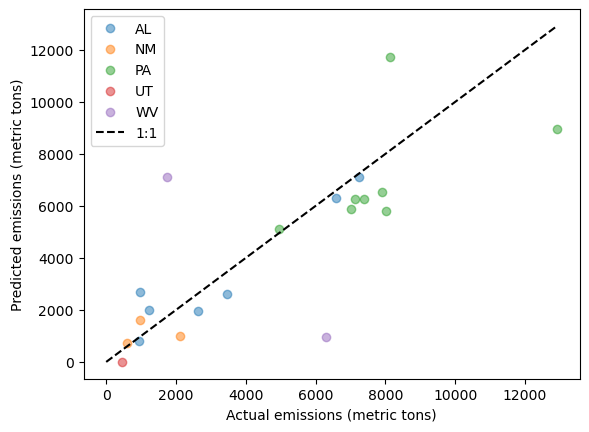

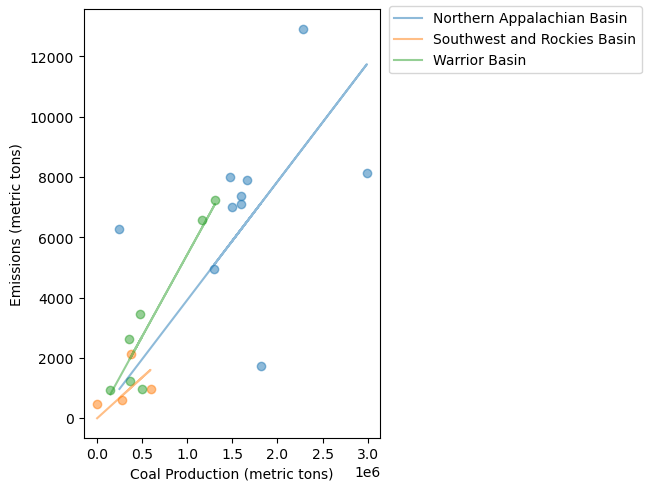

Aggregate metrics


,MAE,RMSE,pearson r,mean bias,total percent bias
0,1500,2200,0.78,-340,-7.3


Metrics by cluster


,MAE,RMSE,pearson r,mean bias,total percent bias,slope,intercept
Northern Appalachian Basin,2500,3100,0.34,-680,-9.6,0.0039,0
Southwest and Rockies Basin,590,690,0.44,-200,-19,0.0027,0
Warrior Basin,650,830,0.94,64,1.9,0.0054,0


'Metrics by state'

,MAE,RMSE,pearson r,mean bias,total percent bias
STATE,,,,,
AL,650,830,0.94,64,1.9
NM,630,750,0.02,-110,-9.2
PA,1800,2200,0.53,-870,-11
UT,460,460,nan,-460,-100
WV,5400,5400,-1,42,1


,slope,intercept
Basin,,
Northern Appalachian Basin,0.003926,0.0
Southwest and Rockies Basin,0.002711,0.0
Warrior Basin,0.005434,0.0


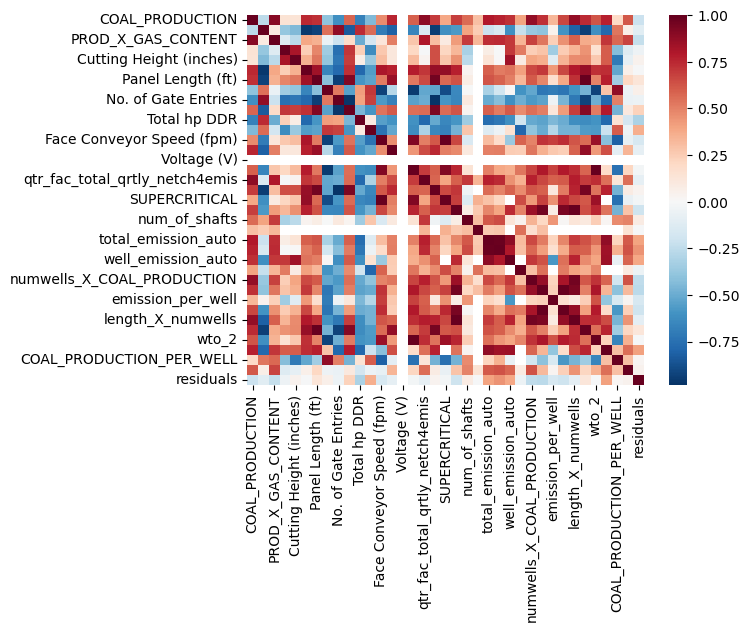

In [10]:
# Supercritical is highly correlated with coal production, which is why it doesn't change much. 
# ['PROD_X_GAS_CONTENT', 'Total hp DDR']+list(one_hot_basin.columns)

filt_df = pred_df[ ((pred_df['vent_vent_id']/pred_df['num_of_shafts'])>0.75)].copy()

model = ClusteredRegression(X_columns=['COAL_PRODUCTION',],
                            y_column='vent_emission_auto', 
                            fit_intercept=False,
                            cluster_columns=['Basin'],)
clean_df = eval.clean_data(filt_df, model)
model.fit(clean_df)
_,_,_ = eval.evaluate_model(model=model, test_df=clean_df)
clean_df['residuals'] = eval.get_residuals(clean_df, model)
sns.heatmap(clean_df[pred_columns+['residuals']].corr(), cmap='RdBu_r', center=0)
basin_models = model.get_params().rename_axis('Basin')
basin_models.reset_index().to_csv('../data/CM_basin_EFs_vent_only.csv', index=False)
basin_models

/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

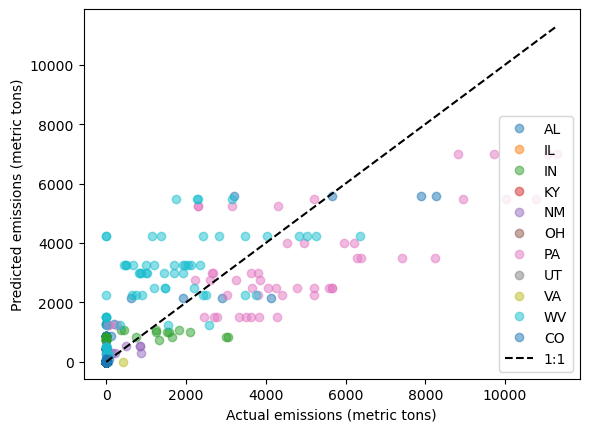

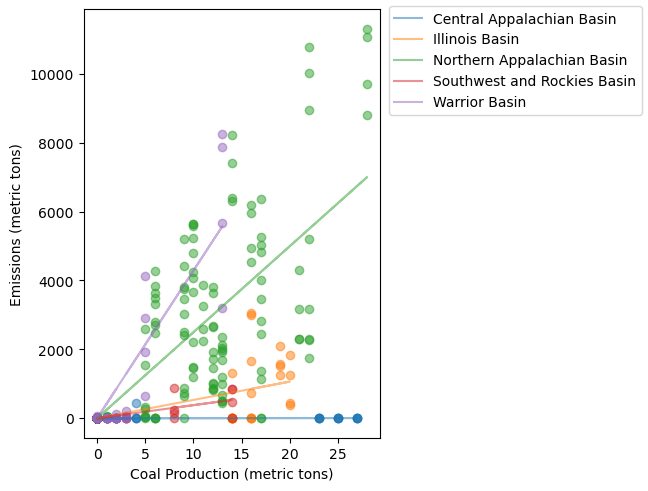

Aggregate metrics


,MAE,RMSE,pearson r,mean bias,total percent bias
0,380,920,0.83,34,5.8


Metrics by cluster


,MAE,RMSE,pearson r,mean bias,total percent bias,slope,intercept
Central Appalachian Basin,7.4,52,-0.0083,-5.3,-83,0.23,0
Illinois Basin,130,380,0.66,6.5,4.7,53,0
Northern Appalachian Basin,540,1200,0.81,16,1.7,250,0
Southwest and Rockies Basin,56,140,0.76,5.9,8,38,0
Warrior Basin,670,940,0.9,340,47,430,0


'Metrics by state'

/home/elise/.conda/envs/cmpro-elise/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/elise/coal/jupyter/evaluate_model.py:78: RuntimeWarning: invalid value encountered in scalar divide
  'total percent bias' : (np.sum(x[predicted_column])-np.sum(x[true_column]))/np.sum(x[true_column])*100,})
/home/elise/.conda/envs/cmpro-elise/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/elise/coal/jupyter/evaluate_model.py:78: RuntimeWarning: invalid value encountered in scalar divide
  'total percent bias' : (np.sum(x[predicted_column])-np.sum(x[true_column]))/np.sum(x[true_column])*100,})
/home/elise/.conda/envs/cmpro-elise/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4427

,MAE,RMSE,pearson r,mean bias,total percent bias
STATE,,,,,
AL,670,940,0.9,340,47
CO,13,38,0.48,13,480
IL,0,0,nan,0,nan
IN,400,660,0.58,20,4.7
KY,0,0,nan,0,nan
NM,290,340,0.33,-12,-2.7
OH,0,0,nan,0,nan
PA,1100,1800,0.89,-770,-30
UT,0,0,nan,0,nan


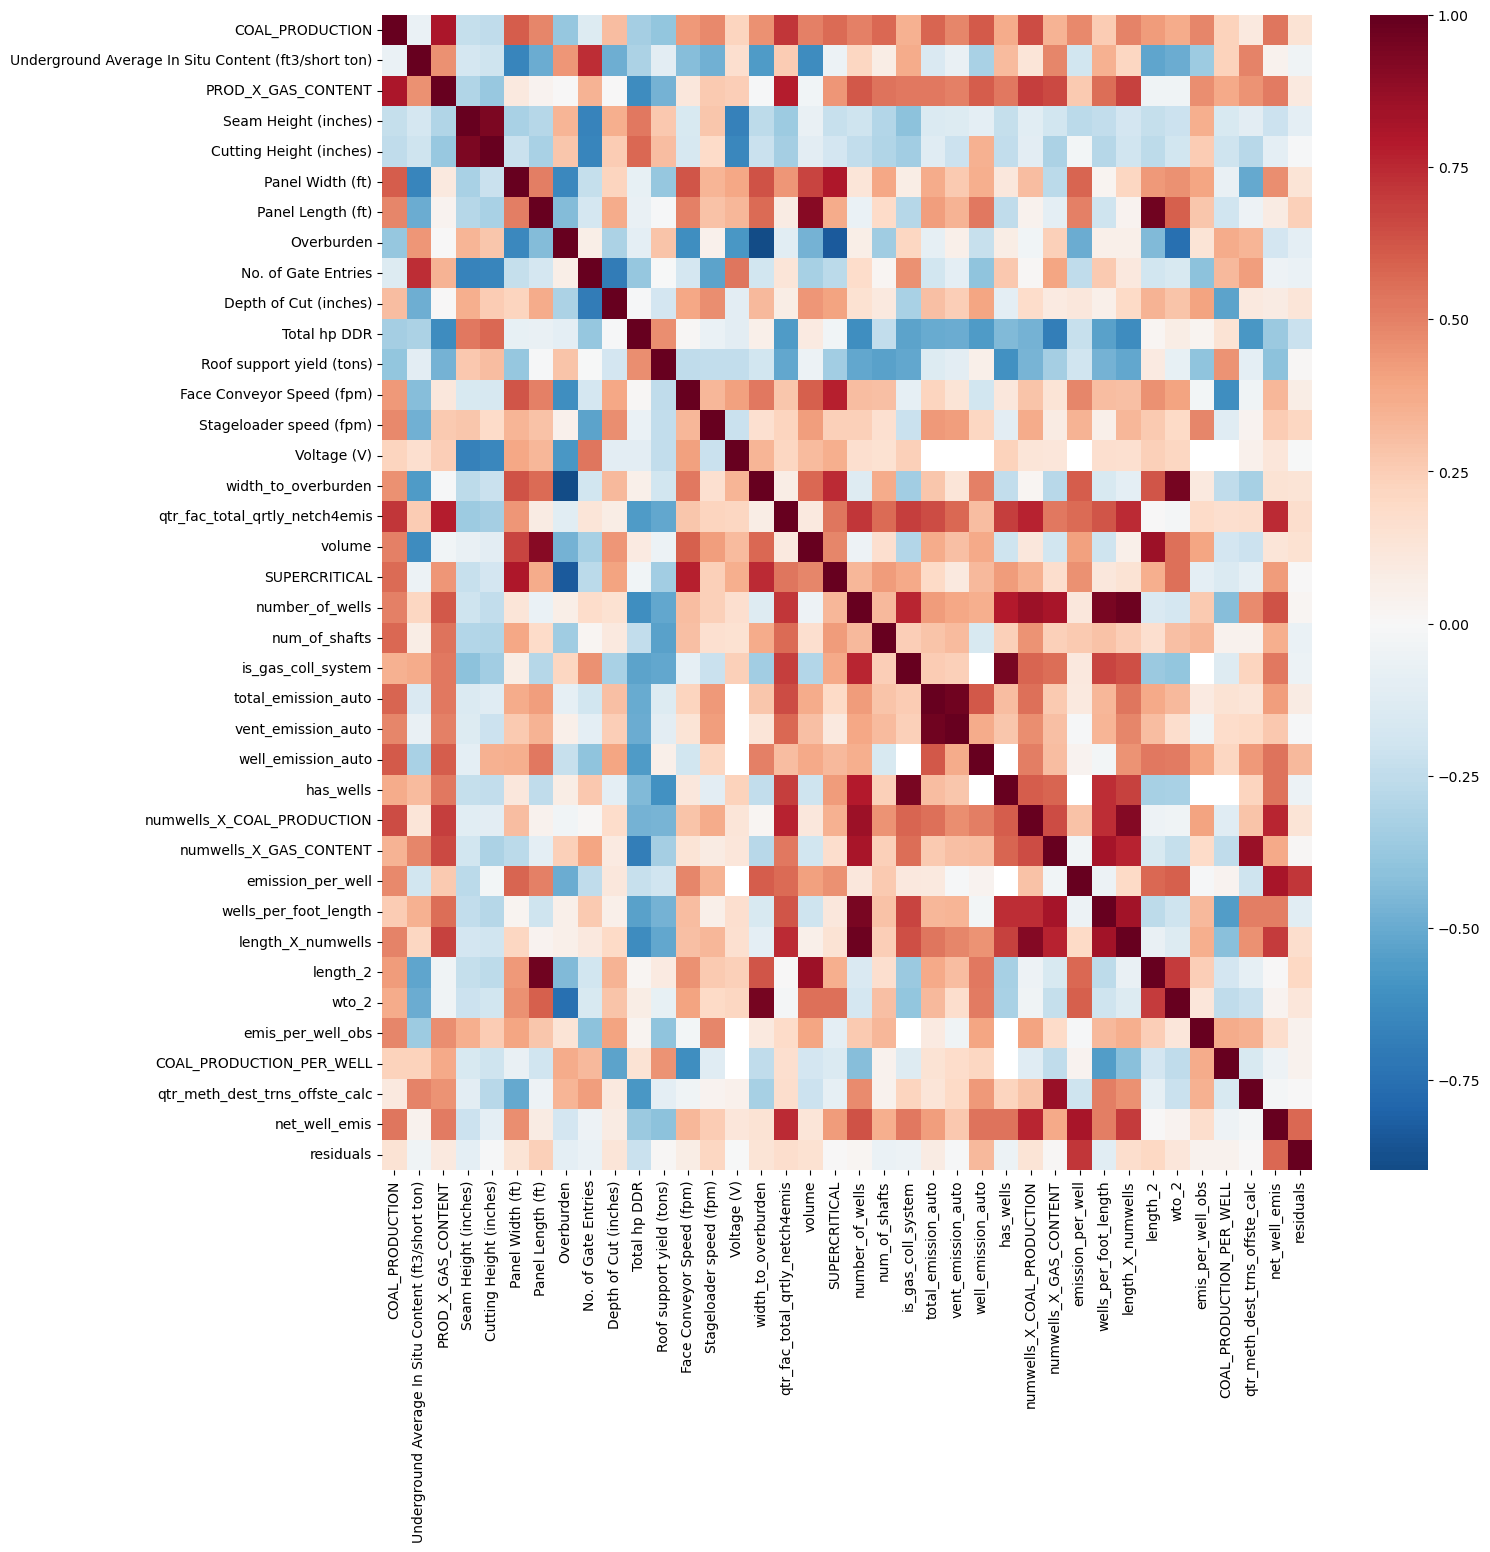

In [11]:
YCOL = 'net_well_emis' #'well_emission_auto'

filt_df = pred_df[(pred_df.reporting_year>=2021)&(~pred_df['Basin'].isnull())]
#'Underground Average In Situ Content (ft3/short ton)', 'width_to_overburden
model = ClusteredRegression(X_columns=['number_of_wells'], #1700,2100 (numwells_X_coal_prod) / 1300,1700 'Panel Length (ft)','Overburden', / 1300,1800 ['width_to_overburden', 'Panel Length (ft)']
                            y_column=YCOL,
                            fit_intercept=False,
                            cluster_columns=['Basin'],)
clean_df = eval.clean_data(filt_df, model)
model.fit(clean_df)
_,_,_ = eval.evaluate_model(model=model, test_df=clean_df)
clean_df['residuals'] = eval.get_residuals(clean_df, model)
plt.figure(figsize=(15,15))
sns.heatmap(clean_df[pred_columns+['net_well_emis', 'residuals']].corr(), cmap='RdBu_r', center=0)
basin_models = model.get_params().rename_axis('Basin')

In [12]:
pred_df[(pred_df.vent_vent_id/pred_df.num_of_shafts)>0.70][['Mine Name','reporting_year','well_emission_auto', 'net_well_emis']].reset_index()

,index,Mine Name,reporting_year,well_emission_auto,net_well_emis
0,133,Oak Grove Mine,2022.0,0.000000,1917.52
1,134,Oak Grove Mine,2022.0,735.700809,4124.58
2,157,No. 4 Coal Mine (AL),2022.0,NaN,0.00
3,158,No. 4 Coal Mine (AL),2022.0,NaN,0.00
4,259,No. 7 Coal Mine,2022.0,NaN,0.00
5,260,No. 7 Coal Mine,2022.0,NaN,0.00
6,283,Shoal Creek Coal Mine,2022.0,NaN,0.00
7,284,Shoal Creek Coal Mine,2022.0,NaN,0.00
8,16071,San Juan Mine 1,2020.0,NaN,120.24
9,16077,San Juan Mine 1,2022.0,NaN,852.12


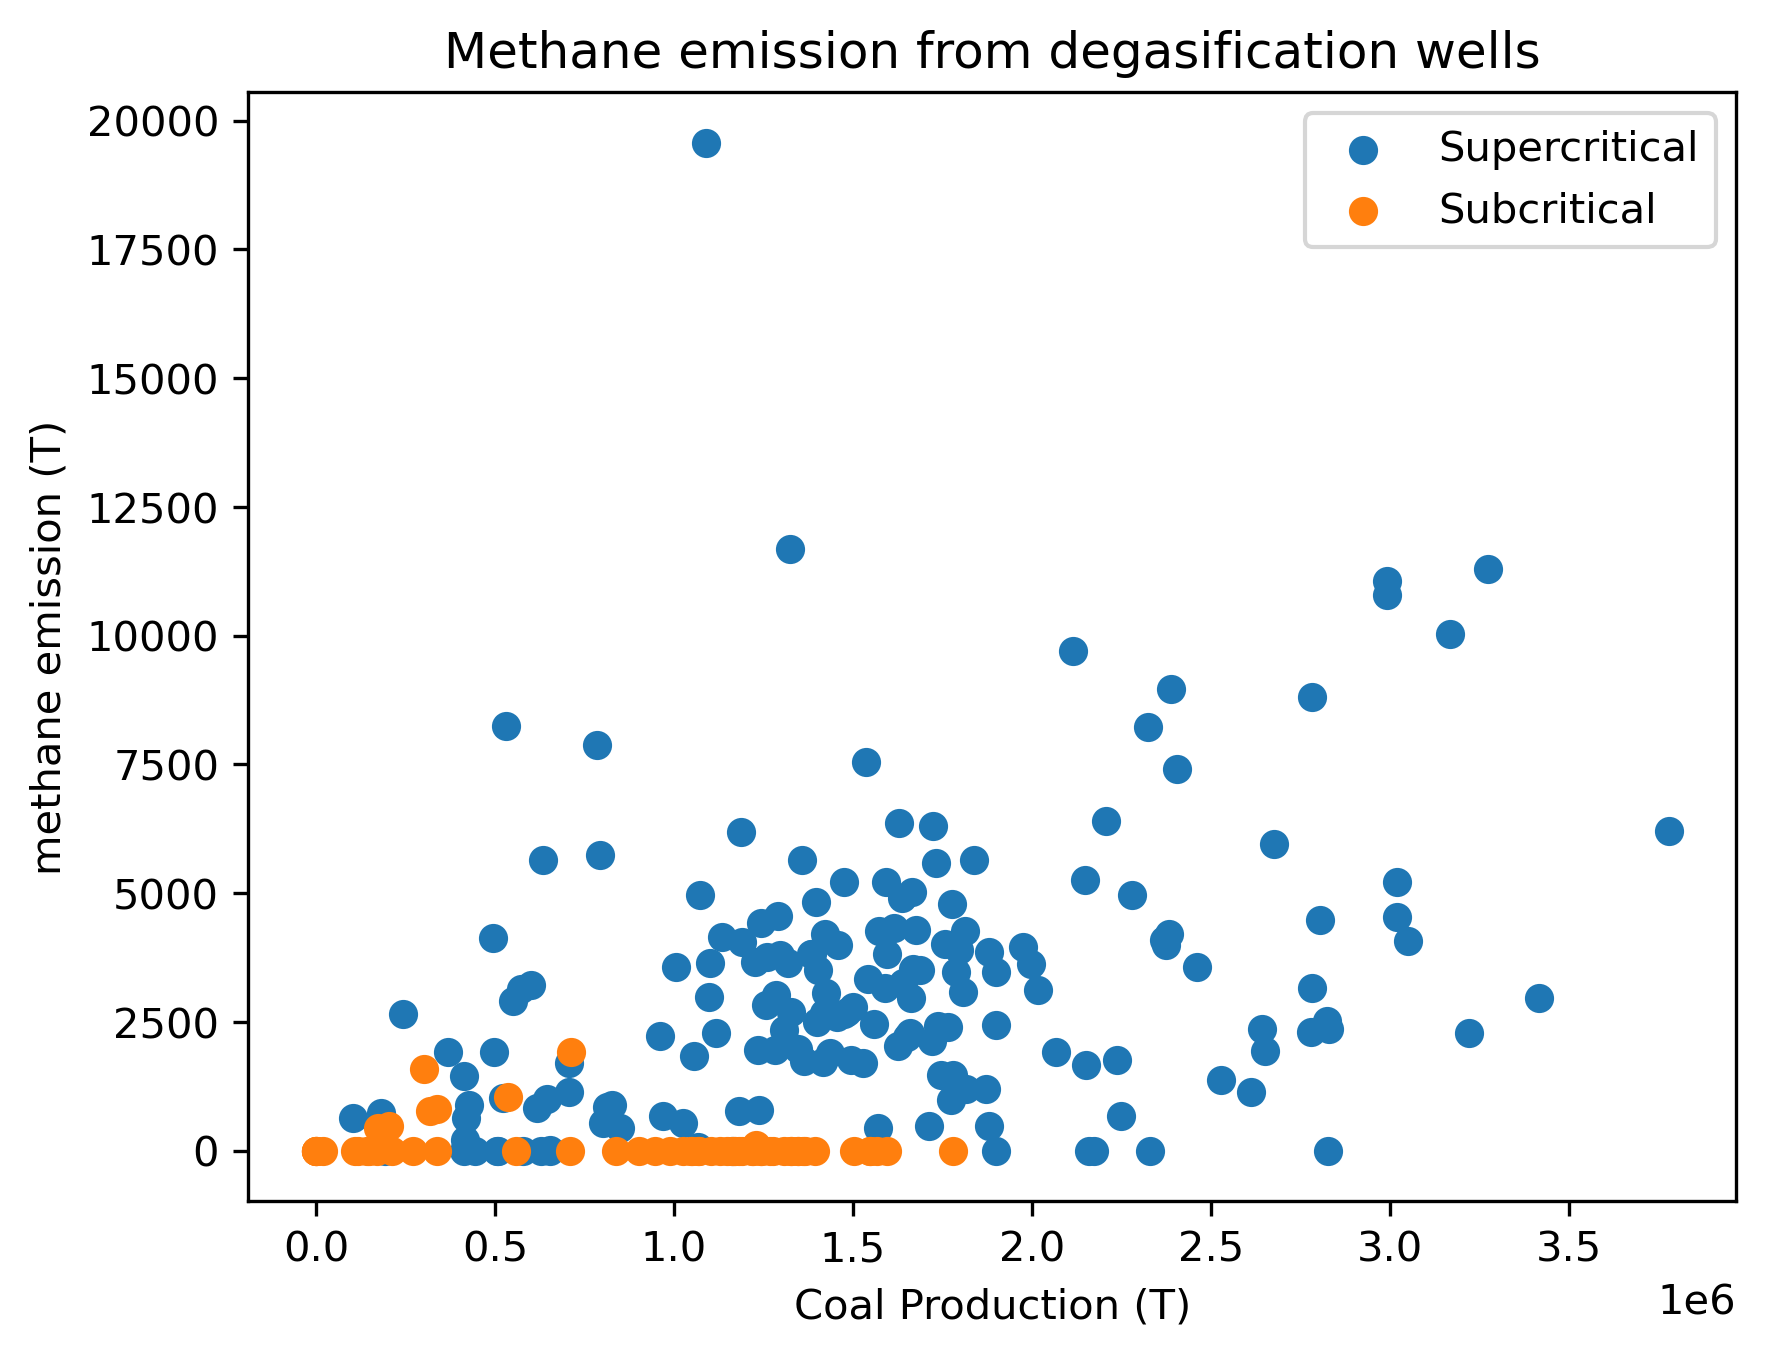

In [ ]:
is_supercritical = pred_df[(~pred_df['Basin'].isnull())&
                  (pred_df['reporting_year']>=2019)&
                  (pred_df['number_of_wells']>0.)&
                  pred_df['Panel Length (ft)'].notnull()]['SUPERCRITICAL'] == 1.

plt.figure(dpi=300)

plt.scatter(pred_df[(~pred_df['Basin'].isnull())&
                  (pred_df['reporting_year']>=2019)&
                  (pred_df['number_of_wells']>0.)&
                  is_supercritical &
                  pred_df['Panel Length (ft)'].notnull()][['COAL_PRODUCTION']], 
            pred_df[(~pred_df['Basin'].isnull())&
                  (pred_df['reporting_year']>=2019)&
                  (pred_df['number_of_wells']>0.)&
                  is_supercritical &
                  pred_df['Panel Length (ft)'].notnull()][['net_well_emis']], 
            label='Supercritical')

plt.scatter(pred_df[(~pred_df['Basin'].isnull())&
                  (pred_df['reporting_year']>=2019)&
                  (pred_df['number_of_wells']>0.)&
                  ~is_supercritical &
                  pred_df['Panel Length (ft)'].notnull()][['COAL_PRODUCTION']], 
            pred_df[(~pred_df['Basin'].isnull())&
                  (pred_df['reporting_year']>=2019)&
                  (pred_df['number_of_wells']>0.)&
                  ~is_supercritical &
                  pred_df['Panel Length (ft)'].notnull()][['net_well_emis']], 
            label='Subcritical')

# plt.scatter(pred_df[(~pred_df['Basin'].isnull())&
#                   (pred_df['reporting_year']>=2019)&
#                   (pred_df['number_of_wells']>0.)&
#                   pred_df['Panel Length (ft)'].isnull()][['COAL_PRODUCTION']], 
#             pred_df[(~pred_df['Basin'].isnull())&
#                   (pred_df['reporting_year']>=2019)&
#                   (pred_df['number_of_wells']>0.)&
#                   pred_df['Panel Length (ft)'].isnull()][['net_well_emis']], label='nolabel')

plt.title('Methane emission from degasification wells')
plt.ylabel('methane emission (T)')
plt.xlabel('Coal Production (T)')
plt.legend()

In [14]:
pred_df[pred_df['Mine Name']=='San Juan Mine 1']['SUPERCRITICAL'] = 1.

/tmp/ipykernel_19356/423085447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df[pred_df['Mine Name']=='San Juan Mine 1']['SUPERCRITICAL'] = 1.


In [15]:
model.get_params()

,slope,intercept
cluster,,
Central Appalachian Basin,0.226698,0.0
Illinois Basin,53.204255,0.0
Northern Appalachian Basin,249.774145,0.0
Southwest and Rockies Basin,38.047435,0.0
Warrior Basin,428.753624,0.0


/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

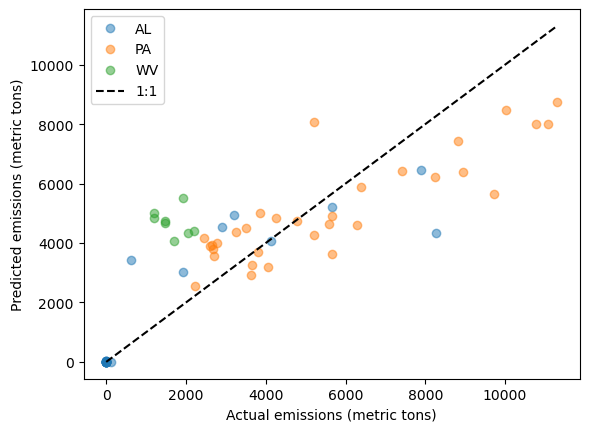

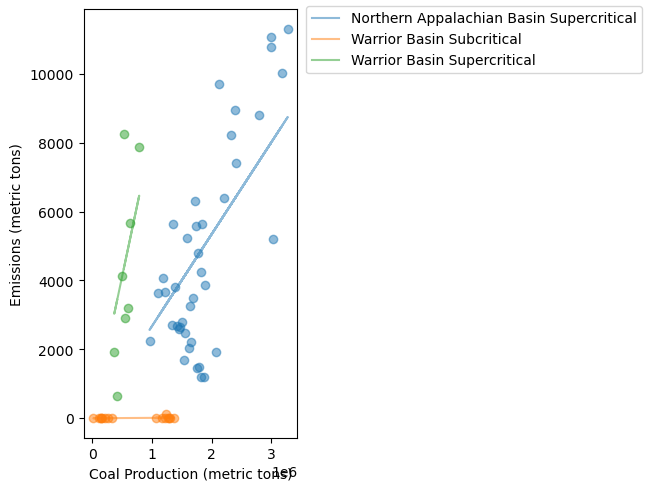

Aggregate metrics


,MAE,RMSE,pearson r,mean bias,total percent bias
0,1300,1800,0.84,160,4.6


Metrics by cluster


,MAE,RMSE,pearson r,mean bias,total percent bias,slope,intercept
Northern Appalachian Basin Supercritical,1700,2000,0.77,220,4.6,0.0027,0
Warrior Basin Subcritical,14,27,0.25,0.73,10,1.1e-05,0
Warrior Basin Supercritical,1600,2000,0.7,180,4.1,0.0082,0


'Metrics by state'

,MAE,RMSE,pearson r,mean bias,total percent bias
STATE,,,,,
AL,550,1200,0.89,59,4.1
PA,1400,1700,0.86,-480,-8.6
WV,3100,3100,-0.27,3100,180


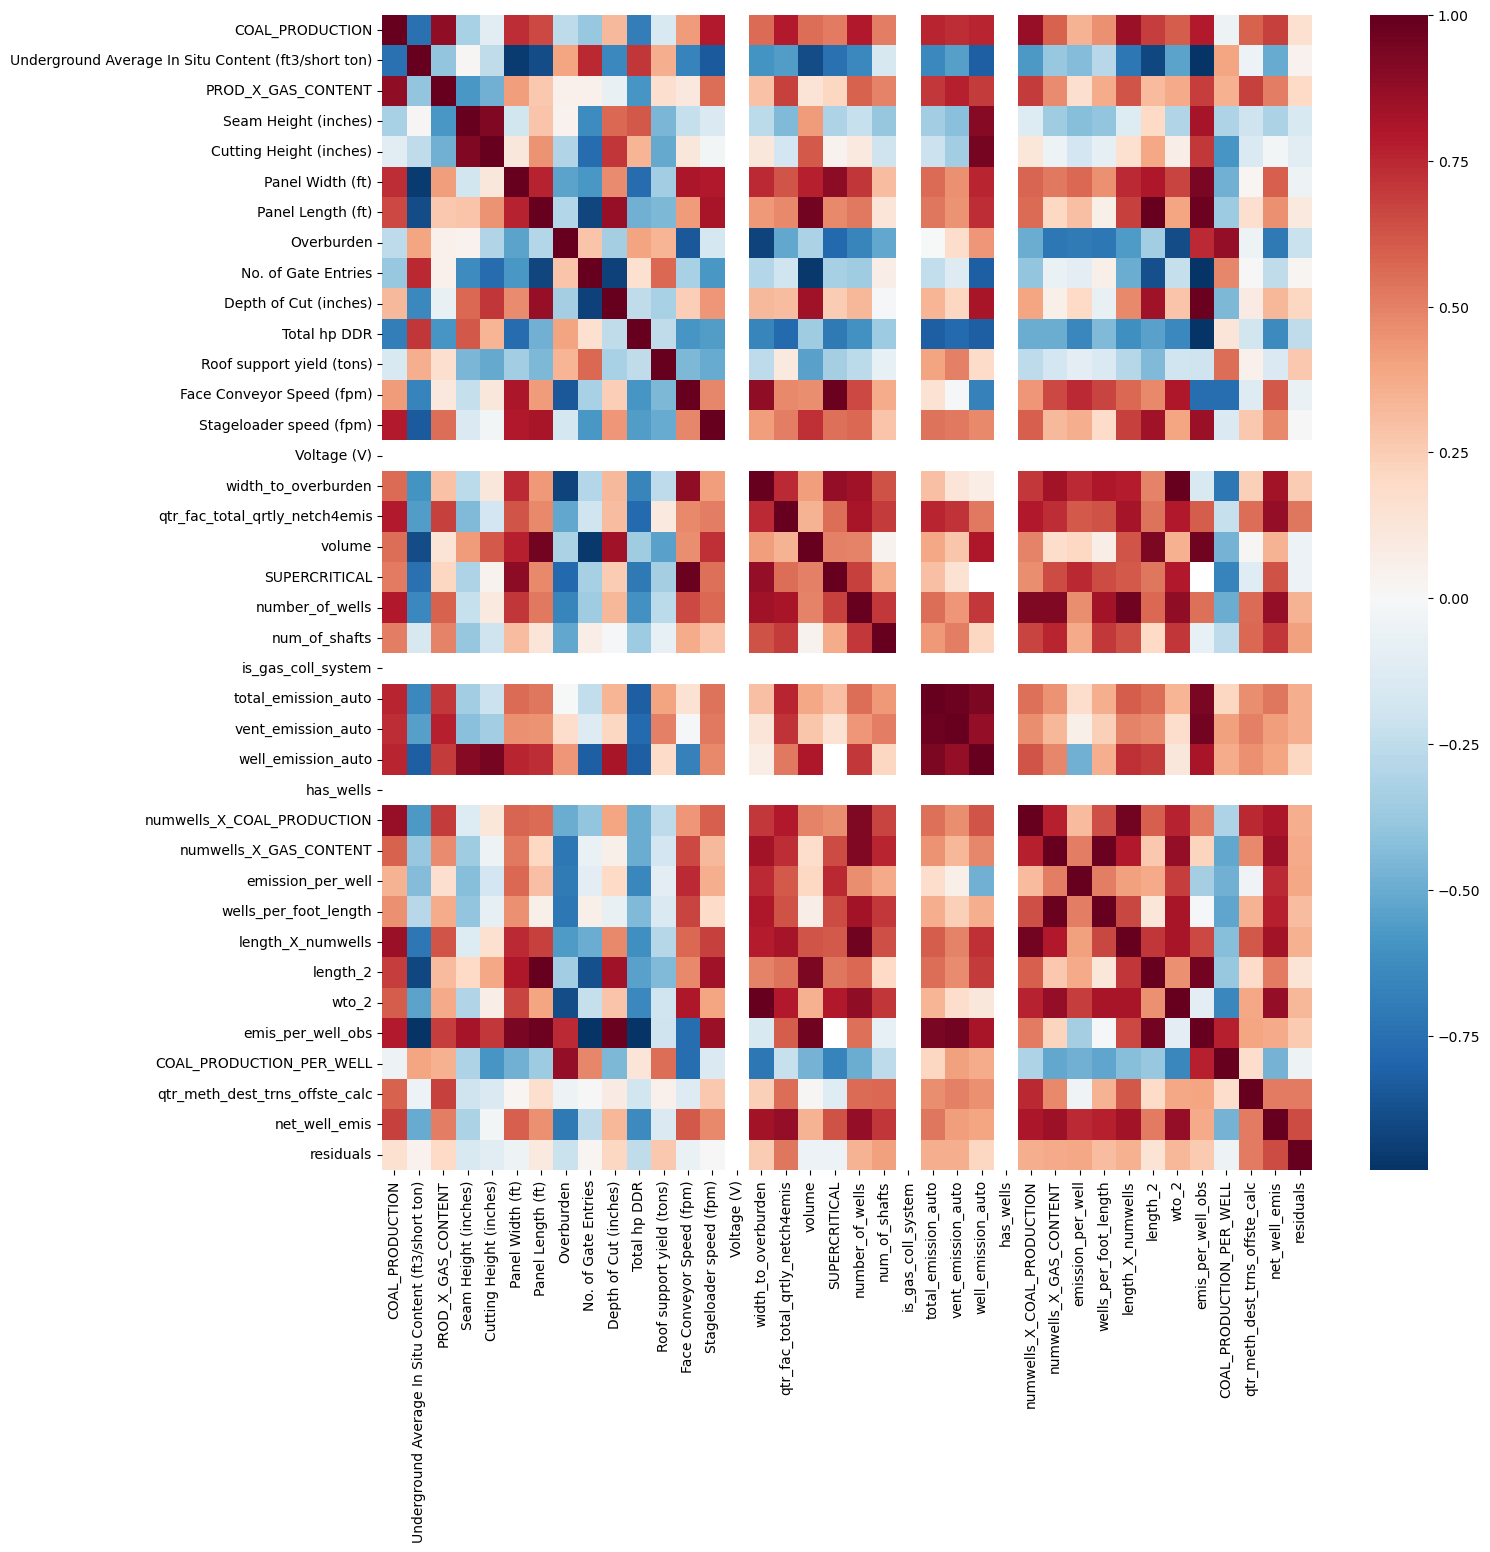

In [16]:
# Supercritical is highly correlated with coal production, which is why it doesn't change much. 
# ['PROD_X_GAS_CONTENT', 'Total hp DDR']+list(one_hot_basin.columns)

# pred_df['wells_per_foot_length'] 
# pred_df['length_X_numwells']

YCOL = 'net_well_emis'#'emission_per_well' #'net_well_emis' #'well_emission_auto'

filt_df = pred_df[(~pred_df['Basin'].isnull())&
                  (pred_df['reporting_year']>=2022)&
                  (pred_df['number_of_wells']>0.)&
                  (pred_df['Panel Length (ft)'].notnull())&
                  (pred_df.facility_name_x.isin(['OAK GROVE MINE', 'WARRIOR MET COAL, LLC', 'SHOAL CREEK MINE',
       'IRON CUMBERLAND, LLC', 'BAILEY MINE-CRABAPPLE PORTAL',
       'ENLOW FORK MINE', 'HARVEY MINE', 'HARRISON COUNTY MINE']))]
#'Underground Average In Situ Content (ft3/short ton)', 'width_to_overburden
model = ClusteredRegression(X_columns=['COAL_PRODUCTION'],#'number_of_wells'], #1700,2100 (numwells_X_coal_prod) / 1300,1700 'Panel Length (ft)','Overburden', / 1300,1800 ['width_to_overburden', 'Panel Length (ft)']
                            y_column=YCOL,
                            fit_intercept=False,
                            cluster_columns=['Basin_Critical'],)
clean_df = eval.clean_data(filt_df, model)
model.fit(clean_df)
_,_,_ = eval.evaluate_model(model=model, test_df=clean_df)
clean_df['residuals'] = eval.get_residuals(clean_df, model)
plt.figure(figsize=(15,15))
sns.heatmap(clean_df[pred_columns+['net_well_emis', 'residuals']].corr(), cmap='RdBu_r', center=0)
basin_models = model.get_params().rename(index={'cluster': 'Basin_Critical'})

/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)


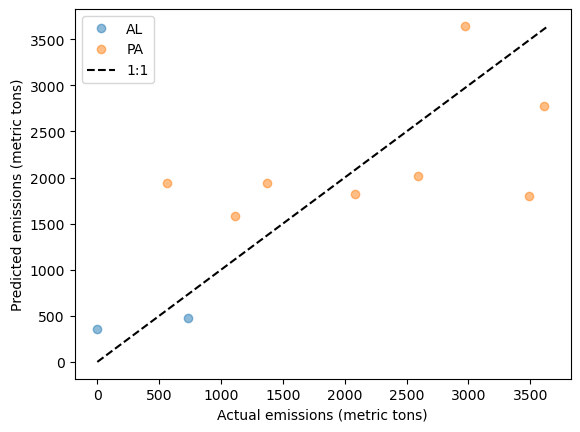

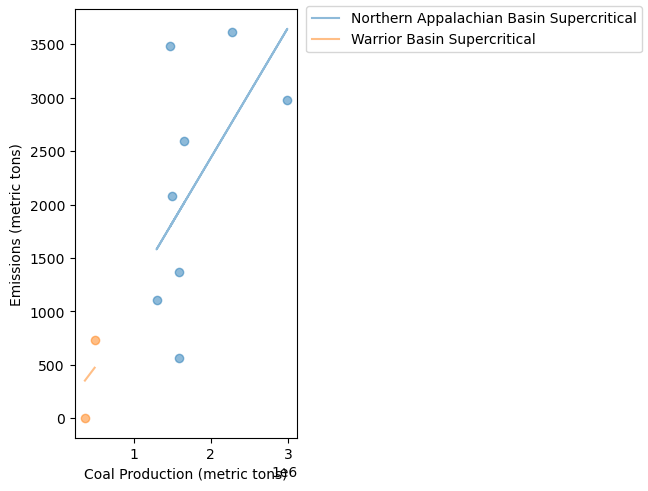

Aggregate metrics


,MAE,RMSE,pearson r,mean bias,total percent bias
0,710,840,0.72,-17,-0.91


Metrics by cluster


,MAE,RMSE,pearson r,mean bias,total percent bias,slope,intercept
Northern Appalachian Basin Supercritical,810,930,0.5,-32,-1.4,0.0012,0
Warrior Basin Supercritical,310,310,1,45,12,0.00095,0


'Metrics by state'

,MAE,RMSE,pearson r,mean bias,total percent bias
STATE,,,,,
AL,310,310,1,45,12
PA,810,930,0.5,-32,-1.4


,slope,intercept,se,pct_se,min_slope,max_slope
Basin_Critical,,,,,,
Northern Appalachian Basin Supercritical,0.001219,0.0,0.000173,0.142034,0.001046,0.001392
Warrior Basin Supercritical,0.000954,0.0,0.000532,0.557806,0.000422,0.001487


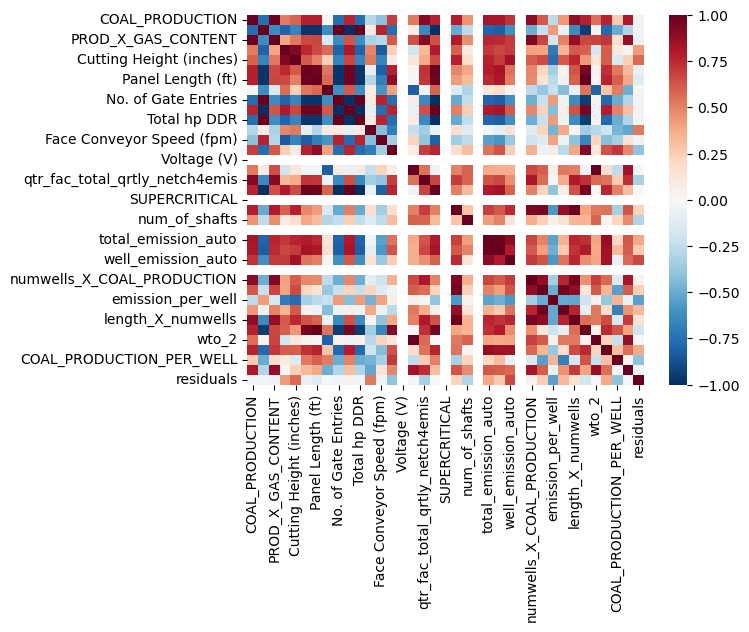

In [17]:
filt_df_gob = pred_df[(pred_df['number_of_wells']>0.)&
                  ((pred_df['vent_vent_id']/pred_df['num_of_shafts'])>=0.749)
                  ].copy()

model_gob = ClusteredRegression(X_columns=['COAL_PRODUCTION',],
                            y_column='well_emission_auto', 
                            fit_intercept=False,
                            cluster_columns=['Basin_Critical'],)
clean_df_gob = eval.clean_data(filt_df_gob, model_gob)
model_gob.fit(clean_df_gob)
_,_,_ = eval.evaluate_model(model=model_gob, test_df=clean_df_gob)
clean_df_gob['residuals'] = eval.get_residuals(clean_df_gob, model_gob)
sns.heatmap(clean_df_gob[pred_columns+['residuals']].corr(), cmap='RdBu_r', center=0)

se_df = get_se_pct(model_gob, clean_df_gob)

basin_models = se_df.rename({"cluster":"Basin_Critical"},axis=1).set_index("Basin_Critical")
basin_models['min_slope'] = basin_models['slope'] - basin_models['se']
basin_models['max_slope'] = basin_models['slope'] + basin_models['se']
basin_models
display(basin_models)

basin_models.reset_index().to_csv('../data/CM_well_EFs.csv', index=False)

In [18]:
clean_df[['idx_facility_id','idx_year_quarter','facility_name_x','predicted_emissions','total_emission_uncertainty_auto']]

,idx_facility_id,idx_year_quarter,facility_name_x,predicted_emissions,total_emission_uncertainty_auto
132,1004512,2022.00,OAK GROVE MINE,3436.720841,NaN
133,1004512,2022.25,OAK GROVE MINE,3033.476914,227.844964
134,1004512,2022.50,OAK GROVE MINE,4069.620345,921.023878
135,1004512,2022.75,OAK GROVE MINE,4529.268168,NaN
136,1004512,2023.00,OAK GROVE MINE,4927.700232,NaN
...,...,...,...,...,...
31758,1008764,2022.75,HARRISON COUNTY MINE,4850.834387,330.924340
31759,1008764,2023.00,HARRISON COUNTY MINE,4755.735915,NaN
31760,1008764,2023.25,HARRISON COUNTY MINE,5001.296305,NaN
31761,1008764,2023.50,HARRISON COUNTY MINE,4668.538490,NaN


In [19]:
clean_df[['idx_facility_id','idx_year_quarter','facility_name_x','predicted_emissions','total_emission_uncertainty_auto']]

,idx_facility_id,idx_year_quarter,facility_name_x,predicted_emissions,total_emission_uncertainty_auto
132,1004512,2022.00,OAK GROVE MINE,3436.720841,NaN
133,1004512,2022.25,OAK GROVE MINE,3033.476914,227.844964
134,1004512,2022.50,OAK GROVE MINE,4069.620345,921.023878
135,1004512,2022.75,OAK GROVE MINE,4529.268168,NaN
136,1004512,2023.00,OAK GROVE MINE,4927.700232,NaN
...,...,...,...,...,...
31758,1008764,2022.75,HARRISON COUNTY MINE,4850.834387,330.924340
31759,1008764,2023.00,HARRISON COUNTY MINE,4755.735915,NaN
31760,1008764,2023.25,HARRISON COUNTY MINE,5001.296305,NaN
31761,1008764,2023.50,HARRISON COUNTY MINE,4668.538490,NaN


In [20]:
clean_df.columns

Index(['idx_msha_id', 'idx_year', 'idx_quarter', 'idx_facility_id',
       'idx_year_quarter', 'MSHA ID_x', 'Coal Type', 'Coal Grade', 'Mine Name',
       'Mine Type',
       ...
       'Warrior Basin_X_PROD_X_GC', 'West Interior Basin', 'volume',
       'LOG_PROD_X_GAS_CONTENT', 'SQRT_PROD_X_GAS_CONTENT', 'length_2',
       'wto_2', 'EF', 'predicted_emissions', 'residuals'],
      dtype='object', length=1881)

/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

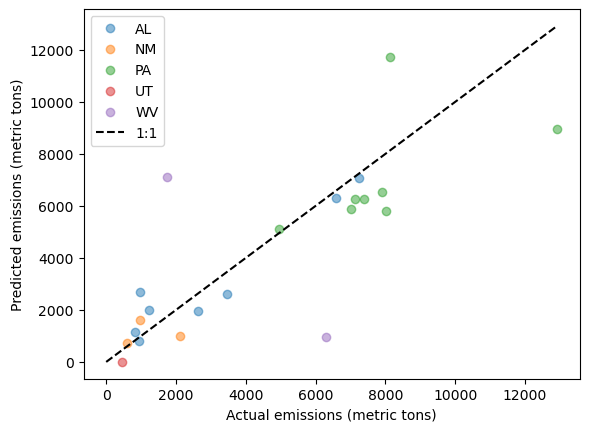

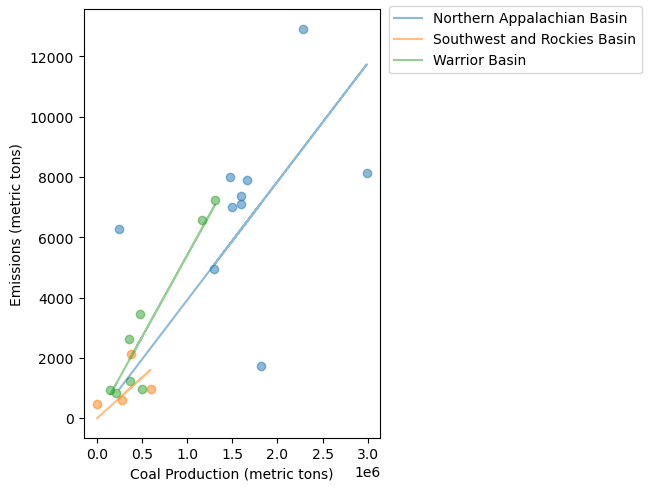

Aggregate metrics


,MAE,RMSE,pearson r,mean bias,total percent bias
0,1500,2200,0.79,-320,-7


Metrics by cluster


,MAE,RMSE,pearson r,mean bias,total percent bias,slope,intercept
Northern Appalachian Basin,2500,3100,0.34,-680,-9.6,0.0039,0
Southwest and Rockies Basin,590,690,0.44,-200,-19,0.0027,0
Warrior Basin,620,790,0.95,86,2.9,0.0054,0


'Metrics by state'

,MAE,RMSE,pearson r,mean bias,total percent bias
STATE,,,,,
AL,620,790,0.95,86,2.9
NM,630,750,0.02,-110,-9.2
PA,1800,2200,0.53,-870,-11
UT,460,460,nan,-460,-100
WV,5400,5400,-1,42,1


,slope,intercept,se,pct_se,min_slope,max_slope
Basin,,,,,,
Northern Appalachian Basin,0.003926,0.0,0.000579,0.147451,0.003347,0.004505
Southwest and Rockies Basin,0.002711,0.0,0.001232,0.454462,0.001479,0.003943
Warrior Basin,0.005417,0.0,0.000467,0.086245,0.004949,0.005884


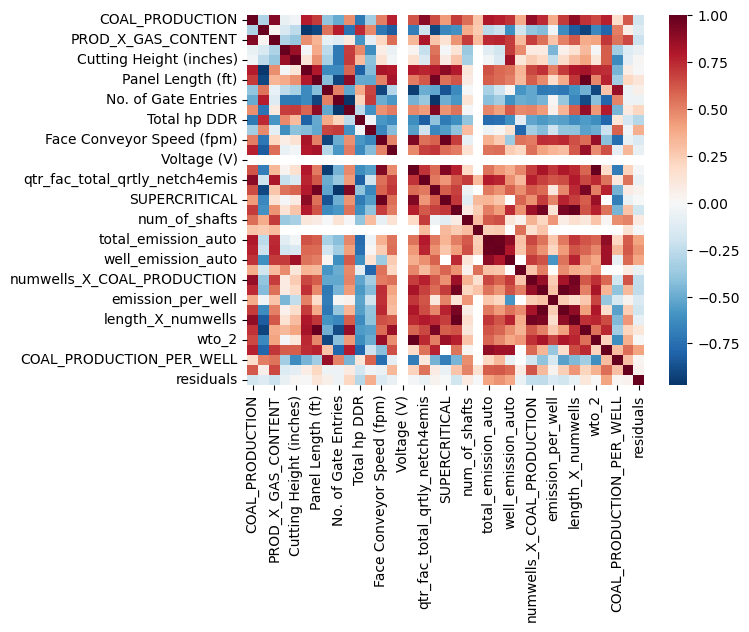

In [21]:
# Supercritical is highly correlated with coal production, which is why it doesn't change much. 
# ['PROD_X_GAS_CONTENT', 'Total hp DDR']+list(one_hot_basin.columns)

filt_df_vent = pred_df[(pred_df['vent_emission_auto']>0) & 
                  ((pred_df['vent_vent_id']/pred_df['num_of_shafts'])>0.749)].copy()

model_vent = ClusteredRegression(X_columns=['COAL_PRODUCTION',],
                            y_column='vent_emission_auto', 
                            fit_intercept=False,
                            cluster_columns=['Basin'],)
clean_df_vent = eval.clean_data(filt_df_vent, model_vent)
model_vent.fit(clean_df_vent)
_,_,_ = eval.evaluate_model(model=model_vent, test_df=clean_df_vent)
clean_df_vent['residuals'] = eval.get_residuals(clean_df_vent, model_vent)
sns.heatmap(clean_df_vent[pred_columns+['residuals']].corr(), cmap='RdBu_r', center=0)
basin_models = model_vent.get_params().rename_axis('Basin')

se_df = get_se_pct(model_vent, clean_df_vent)

basin_models = se_df.rename({"cluster":"Basin"},axis=1).set_index("Basin")
basin_models['min_slope'] = basin_models['slope'] - basin_models['se']
basin_models['max_slope'] = basin_models['slope'] + basin_models['se']
basin_models
display(basin_models)

basin_models.reset_index().to_csv('../data/CM_basin_EFs.csv', index=False)

/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)


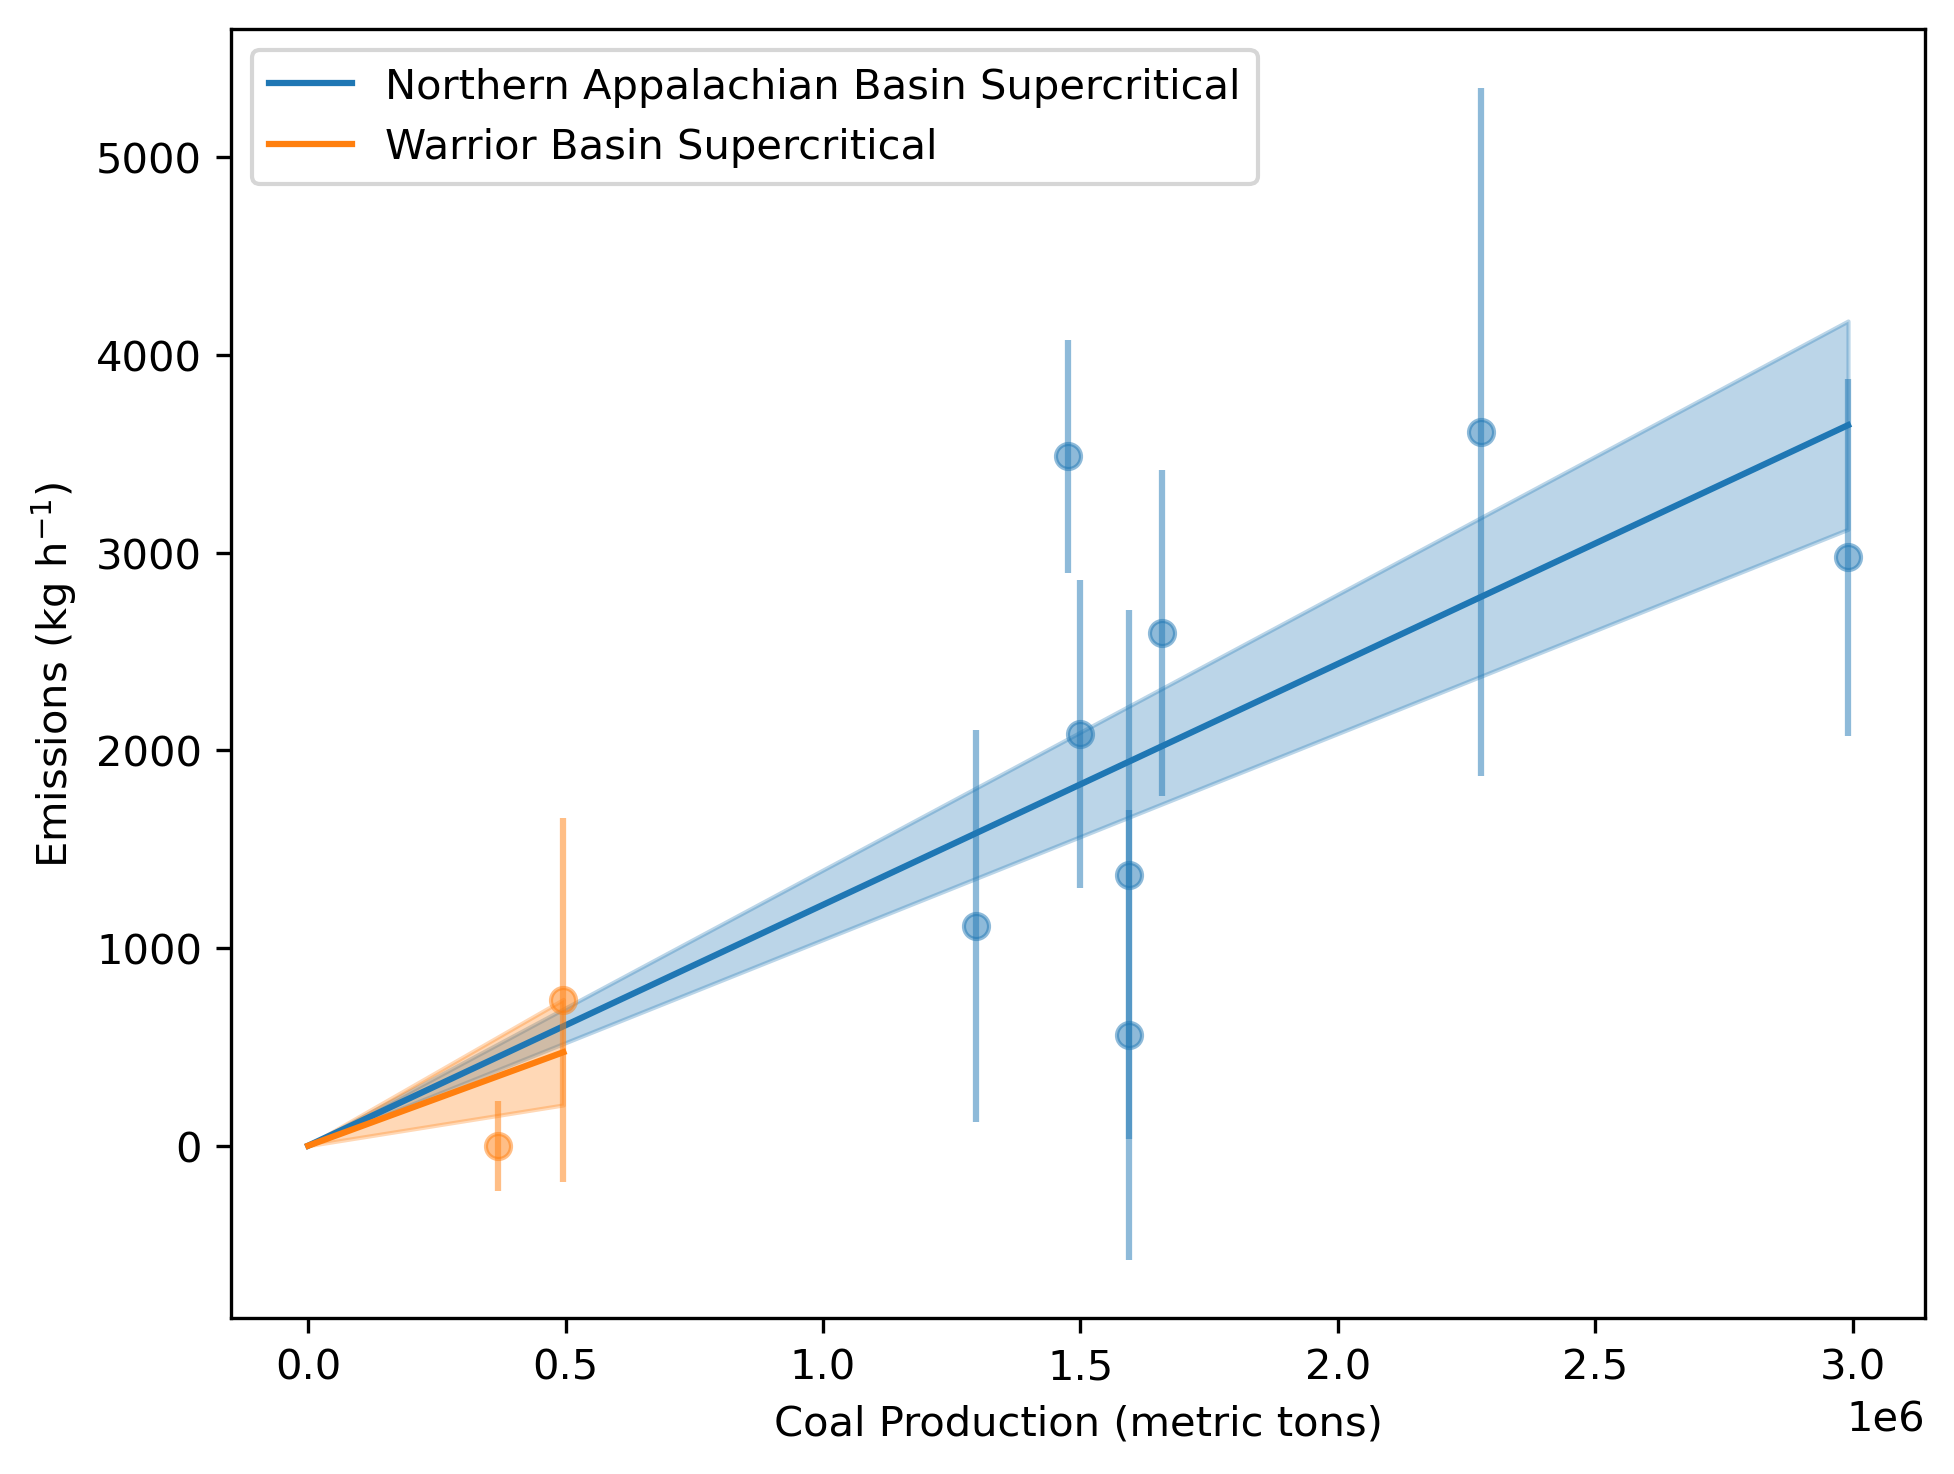

                                    cluster     slope  intercept        se  \
0  Northern Appalachian Basin Supercritical  0.001219        0.0  0.000176   
1               Warrior Basin Supercritical  0.000954        0.0  0.000538   

     pct_se  
0  0.144522  
1  0.564212  


/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

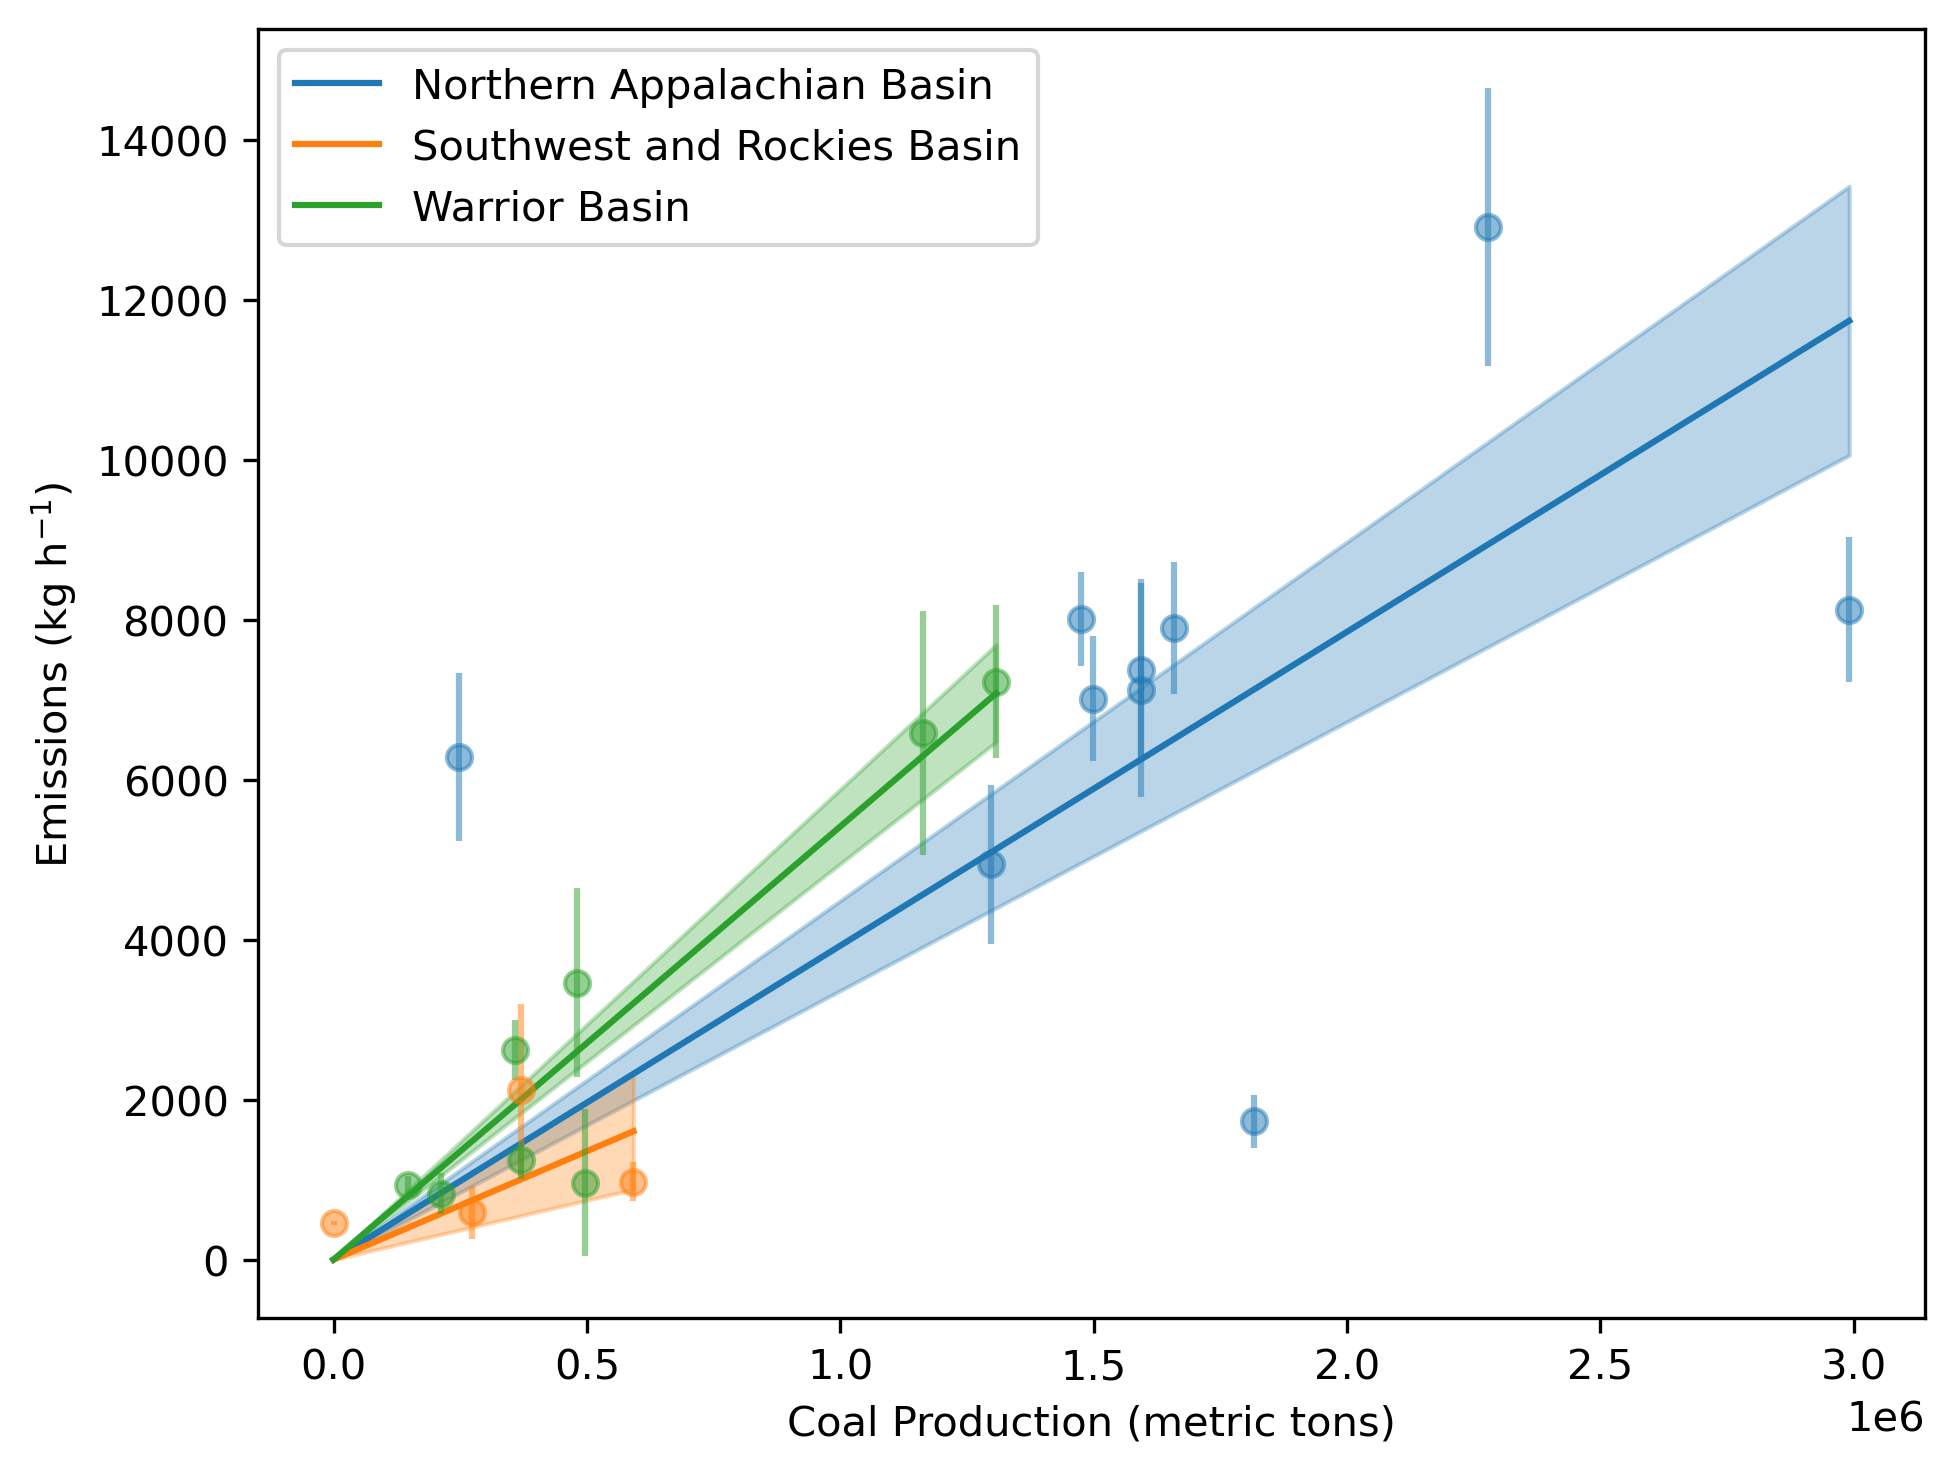

                       cluster     slope  intercept        se    pct_se
0   Northern Appalachian Basin  0.003926        0.0  0.000563  0.143271
1  Southwest and Rockies Basin  0.002711        0.0  0.001228  0.452981
2                Warrior Basin  0.005417        0.0  0.000465  0.085888


In [22]:
plot_2d_model_w_err(clean_df_gob, model_gob, cluster_list = None)
plot_2d_model_w_err(clean_df_vent, model_vent, cluster_list=['Warrior Basin', 'Southwest and Rockies Basin', 'Northern Appalachian Basin'])

In [23]:
get_se_pct(model_gob, clean_df_gob)

,cluster,slope,intercept,se,pct_se
0,Northern Appalachian Basin Supercritical,0.001219,0.0,0.000172,0.140835
1,Warrior Basin Supercritical,0.000954,0.0,0.000534,0.559263


natural units: 

y: KG / HR

x: T / qtr

/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

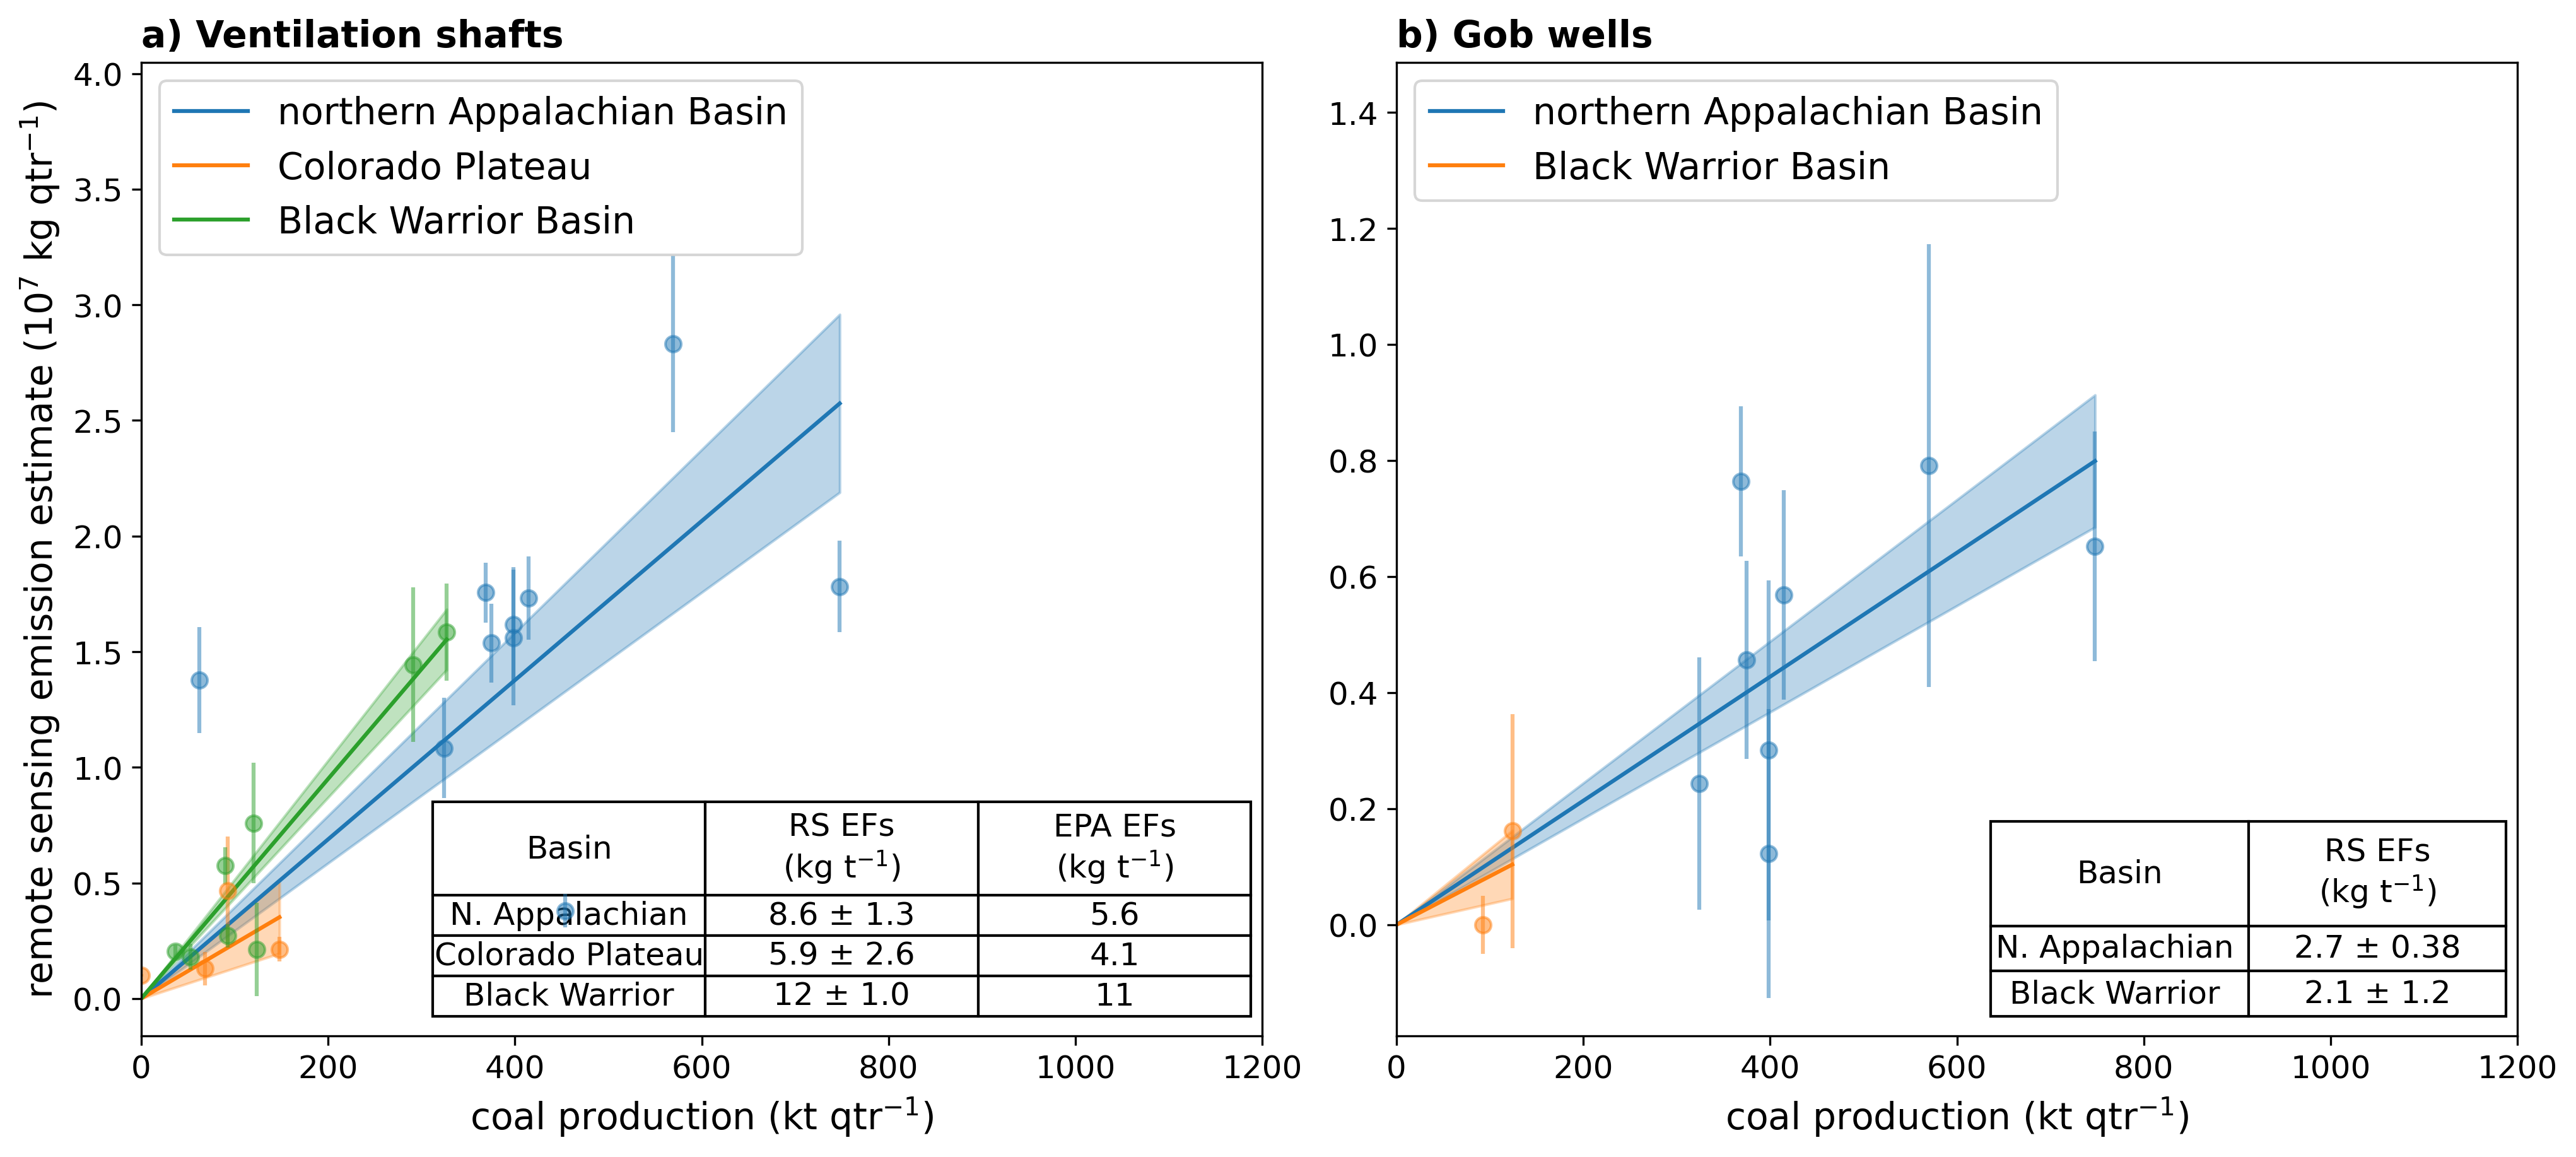

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_2d_model_w_err_panel(pred_df_vent, model_vent, pred_df_gob, model_gob,
                               error_col='total_emission_uncertainty_auto',
                               vent_clusters=None, alt_slope_dict=None,
                               font_size=14,):
    fig, axs = plt.subplots(1, 2, figsize=(13.5, 6), dpi=300, layout='constrained')

    def plot_single(ax, pred_df, model, title, is_ventilation=False, show_ylabel=True):
        model.predict(pred_df)
        se_df = get_se_pct(model, pred_df)

        # Convert units
        pred_df = pred_df.copy()
        pred_df[model.X_columns[0]] = pred_df[model.X_columns[0]] / 4000.0  # kt/qtr
        pred_df[model.y_column] = pred_df[model.y_column] * 2191.5 * 1e-7         # 10^7 kg/qtr
        pred_df[model.predicted_column] = pred_df[model.predicted_column] * 2191.5 * 1e-7 # 10^7 kg/qtr 
        pred_df[error_col] = pred_df[error_col] * 2191.5 * 1e-7 # 10^7 kg/qtr

        for cluster in model.models.keys():
            if is_ventilation and (vent_clusters is not None) and (cluster not in vent_clusters):
                continue
            pct_err = float(se_df.loc[se_df.cluster == cluster, 'pct_se'])
            subset = pred_df[model.cluster_data(pred_df) == cluster]
            if subset.empty:
                continue
            subset = subset.sort_values(by=model.X_columns)
            label = basin_names_replacement[cluster.replace('Supercritical', '').replace('Basin ','Basin')]
            dots = ax.errorbar(subset[model.X_columns], subset[model.y_column],
                               yerr=subset[error_col], fmt='o', alpha=0.5)
            ax.plot(np.append([0.], subset[model.X_columns]),
                    np.append([0.], subset[model.predicted_column]),
                    label=label, color=dots[0].get_color())
            ax.fill_between(np.append([0.], subset[model.X_columns].squeeze()),
                            np.append([0.], (subset[model.predicted_column] * (1. - pct_err)).squeeze()),
                            np.append([0.], (subset[model.predicted_column] * (1. + pct_err)).squeeze()),
                            color=dots[0].get_color(), alpha=0.3)

        ax.set_ylim(top=ax.get_ylim()[1] * 1.2)  # increase top by 20%
        ax.set_xlim(0, 1200)
        ax.set_xlabel('coal production (kt qtr$^{-1}$)', fontsize=font_size)
        if show_ylabel:
            ax.set_ylabel('remote sensing emission estimate ($10^7$ kg qtr$^{-1}$)', fontsize=font_size)
        ax.tick_params(labelsize=font_size - 2)
        ax.legend(loc='upper left', fontsize=font_size)
        ax.set_title(title, loc='left', fontweight='bold', fontsize=font_size)

        # Build table
        slope_data = []
        for cluster in model.models.keys():
            slope = model.models[cluster].coef_[0] / utils.MT_QRT_TO_KG_HR / utils.KG_TO_MT  # Converts (kg/hr)/(t/qtr) → kg/t
            se = se_df.loc[se_df.cluster == cluster, 'se'].values[0] / utils.MT_QRT_TO_KG_HR / utils.KG_TO_MT # Converts (kg/hr)/(t/qtr) → kg/t
            slope_fmt = f'{utils.format_sigfigs(slope)} ± {utils.format_sigfigs(se)}'
            # Clean up basin names
            basin = cluster.replace(' Basin', '').replace('Northern', 'N.'
                                ).replace('Southwest and Rockies', 'Colorado Plateau').replace('Supercritical',''
                                ).replace('and','&').replace('Warrior', 'Black Warrior')

            if is_ventilation:
                alt_val = alt_slope_dict.get(cluster, '0.00 ± 0.00') if alt_slope_dict else '0.00 ± 0.00'
                slope_data.append([basin, slope_fmt, alt_val])
            else:
                slope_data.append([basin, slope_fmt])
                
        col_labels = ['Basin', 'RS EFs\n(kg t$^{-1}$)'] if not is_ventilation else \
                    ['Basin', 'RS EFs\n(kg t$^{-1}$)', 'EPA EFs\n(kg t$^{-1}$)']


        # Wider bbox for 2-column (ventilation) table
        table_bbox = [0.26, 0.02, 0.73, 0.22] if is_ventilation else [0.53, 0.02, 0.46, 0.2]
        table = ax.table(cellText=slope_data, colLabels=col_labels,
                        colLoc='center', cellLoc='center',
                        loc='lower right', bbox=table_bbox)
        table.auto_set_font_size(False)
        table.set_fontsize(font_size-2)
        table.scale(1, 1.2)

        # Make header row (row 0) taller for multi-line labels
        for col_idx in range(len(col_labels)):
            cell = table[(0, col_idx)]
            cell.set_height(0.1)  # increased from 0.08


    # Left = ventilation (a), Right = gob wells (b)
    plot_single(axs[0], pred_df_vent, model_vent, 'a) Ventilation shafts', is_ventilation=True, show_ylabel=True)
    plot_single(axs[1], pred_df_gob, model_gob, 'b) Gob wells', is_ventilation=False, show_ylabel=False)


plot_2d_model_w_err_panel(
    clean_df_vent, model_vent,
    clean_df_gob, model_gob,
    vent_clusters=['Warrior Basin', 'Southwest and Rockies Basin', 'Northern Appalachian Basin'],
    alt_slope_dict={
        'Warrior Basin': '11',
        'Southwest and Rockies Basin': '4.1',
        'Northern Appalachian Basin': '5.6'
    },
    font_size=14
)
plt.savefig('./figures/figure_5.png')
plt.show()

/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[self.predicted_column] = self.models[cluster].predict(X)
/home/elise/coal/jupyter/clustered_regression.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

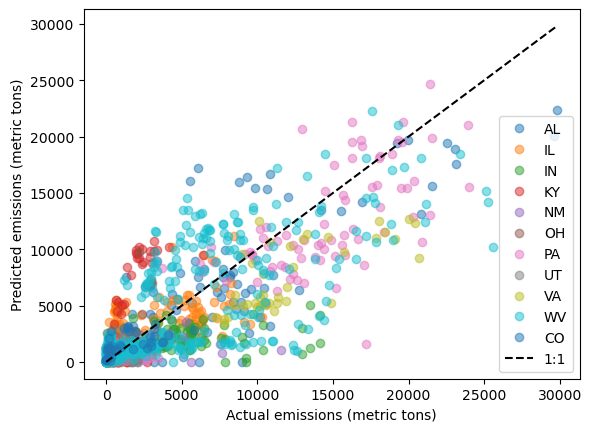

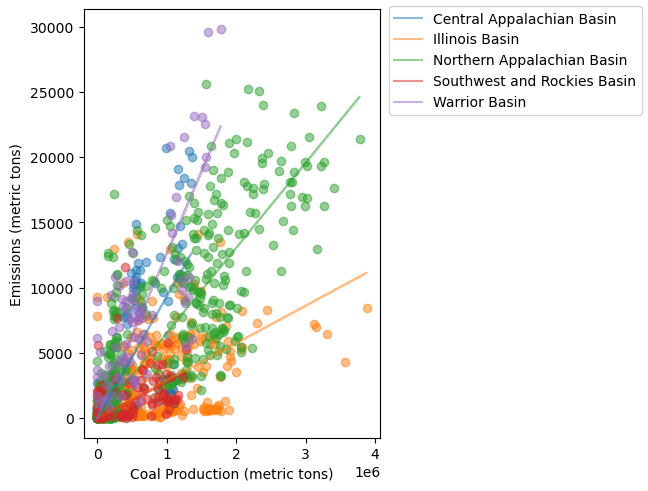

Aggregate metrics


,MAE,RMSE,pearson r,mean bias,total percent bias
0,2300,3400,0.79,-450,-10


Metrics by cluster


,MAE,RMSE,pearson r,mean bias,total percent bias,slope,intercept
Central Appalachian Basin,2900,4100,0.69,-270,-6,0.0093,0
Illinois Basin,2300,3200,0.31,-620,-19,0.0029,0
Northern Appalachian Basin,2200,3300,0.84,-390,-8.3,0.0065,0
Southwest and Rockies Basin,1300,2000,0.23,-410,-21,0.0027,0
Warrior Basin,3300,4200,0.77,-660,-7.8,0.013,0


'Metrics by state'

,MAE,RMSE,pearson r,mean bias,total percent bias
STATE,,,,,
AL,3300,4200,0.77,-660,-7.8
CO,990,1200,0.58,260,19
IL,1800,2300,0.59,740,33
IN,3200,4300,0.31,-3200,-62
KY,2200,3500,0.75,1800,160
NM,3000,4000,0.054,-2900,-67
OH,1900,2900,0.78,1700,86
PA,2300,3300,0.92,-1500,-19
UT,960,1100,0.32,2.1,0.16


,slope,intercept
Basin,,
Central Appalachian Basin,0.009304,0.0
Illinois Basin,0.002872,0.0
Northern Appalachian Basin,0.006520,0.0
Southwest and Rockies Basin,0.002749,0.0
Warrior Basin,0.012581,0.0


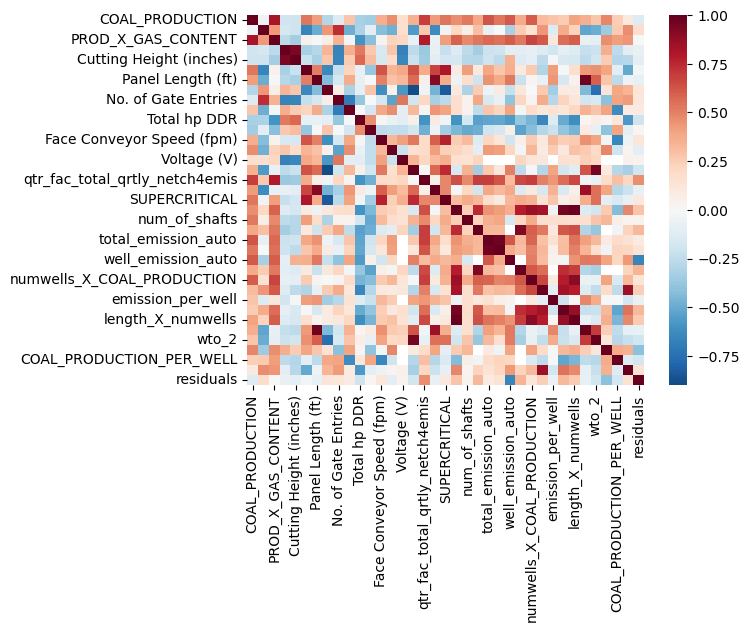

In [25]:
# Supercritical is highly correlated with coal production, which is why it doesn't change much. 
# ['PROD_X_GAS_CONTENT', 'Total hp DDR']+list(one_hot_basin.columns)
model = ClusteredRegression(X_columns=['COAL_PRODUCTION'],
                            y_column='qtr_meth_liber_vent_calc',#'qtr_fac_total_qrtly_netch4emis', 
                            fit_intercept=False,
                            cluster_columns=['Basin'],)
clean_df = eval.clean_data(pred_df, model)
model.fit(clean_df)
_,_,_ = eval.evaluate_model(model=model, test_df=clean_df)
clean_df['residuals'] = eval.get_residuals(clean_df, model)
sns.heatmap(clean_df[pred_columns+['residuals']].corr(), cmap='RdBu_r', center=0)
basin_models = model.get_params().rename_axis('Basin')
basin_models.reset_index().to_csv('../data/EPA_Basin_EFs.csv', index=False)
basin_models